In [2252]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyballmapper as pbm
import geopandas as gpd 
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cm
import kmapper as km
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from matplotlib.colors import LinearSegmentedColormap



In [2253]:
# Load the data
resident = pd.read_excel('/Users/adamsarissky/Desktop/ERP/ASHE_resident_district.xlsx', skiprows = 8, skipfooter=7)
# Load Northern Ireland data
NI_data = pd.read_excel('/Users/adamsarissky/Desktop/ERP/NI_ASHE_Resident_Fulltime.xlsx')
# load the urban rural classification
urban_rural = pd.read_excel('/Users/adamsarissky/Desktop/ERP/urban_rural.xlsx', sheet_name=2, skiprows=1, usecols=['Local authority code', 'Local authority name', 'Summary_Classification'])
# local authorities to regions classification
regions = pd.read_excel('/Users/adamsarissky/Desktop/ERP/LA_to_region.xlsx')

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [2254]:
# Cleaning data by removing the confidence intervals.  
columns_to_drop = [col for col in resident.columns if 'Unnamed' in str(col)]
resident_cleaned = resident.drop(columns=columns_to_drop)

In [2255]:
# remove the first row
resident_cleaned = resident_cleaned.iloc[1:]

In [2256]:
# inspect the data
resident_cleaned.head()

local authority: district / unitary (as of April 2023)   2015   2016   2017  \
1                                            Babergh      27757      #  31086   
2                                           Basildon      29217  30560  29839   
3                                            Bedford      28030  29564  30250   
4                                          Braintree          #  31481  31793   
5                                          Breckland      23408  24329  24050   

    2018   2019   2020   2021   2022   2023  
1  29634  31581  31799  30000  31163  30901  
2  31084  32748  32597  32749  33642  36802  
3  29741  31624  34562  31039  33499      #  
4  32464  33681  33294  31900  36073  36674  
5  26041  26208  26582  26941  30022  31807

In [2257]:
# rename columns
resident_cleaned.rename(columns={'local authority: district / unitary (as of April 2023)': 'Local_Authority'}, inplace=True)

In [2258]:
NI_data.head()

Local_Authority       Code   2015   2016   2017  \
0               Antrim and Newtownabbey  N09000001  25956  27698  26946   
1                   Ards and North Down  N09000011  26236  26094  27000   
2  Armagh City, Banbridge and Craigavon  N09000002  23139  24650  26174   
3                               Belfast  N09000003  26496  26662  25903   
4              Causeway Coast and Glens  N09000004  22913  22102  21430   

    2018   2019   2020   2021   2022   2023  
0  28873  27454  29203  29864  30124  32454  
1  27176  27493  28018  29150  29750  33436  
2  26710  27799  29032  30826  30031  32893  
3  26594  27732  27986  28672  30018  32337  
4  23162  23877  24831  24610  28820  29004

In [2259]:
# drop unecessary column
NI_data.drop('Code', axis=1, inplace=True)

In [2260]:
# pivot longer the data
NI_data = pd.melt(NI_data, id_vars=['Local_Authority'], var_name='Year', value_name='Median_Salary')

In [2261]:
# inspect data agian
NI_data.head()

Local_Authority  Year Median_Salary
0               Antrim and Newtownabbey  2015         25956
1                   Ards and North Down  2015         26236
2  Armagh City, Banbridge and Craigavon  2015         23139
3                               Belfast  2015         26496
4              Causeway Coast and Glens  2015         22913

In [2262]:
# inspect EN, scotland and wales data
resident_cleaned.head()

Local_Authority   2015   2016   2017   2018   2019   2020   2021   2022  \
1         Babergh  27757      #  31086  29634  31581  31799  30000  31163   
2        Basildon  29217  30560  29839  31084  32748  32597  32749  33642   
3         Bedford  28030  29564  30250  29741  31624  34562  31039  33499   
4       Braintree      #  31481  31793  32464  33681  33294  31900  36073   
5       Breckland  23408  24329  24050  26041  26208  26582  26941  30022   

    2023  
1  30901  
2  36802  
3      #  
4  36674  
5  31807

In [2263]:
# pibot longer the residents data 
long_resident = pd.melt(resident_cleaned, id_vars=['Local_Authority'], var_name='Year', value_name='Median_Salary')

In [2264]:
# inspect the data
long_resident.head()

Local_Authority  Year Median_Salary
0         Babergh  2015         27757
1        Basildon  2015         29217
2         Bedford  2015         28030
3       Braintree  2015             #
4       Breckland  2015         23408

In [2265]:
# subset Norther Ireland data to columns of interest 
NI_data = NI_data[['Local_Authority', 'Year', 'Median_Salary']]

# Concatenate NI data to the rest
long_resident = pd.concat([long_resident, NI_data], ignore_index=True)


In [2266]:
# inspect the data
long_resident.head()

Local_Authority  Year Median_Salary
0         Babergh  2015         27757
1        Basildon  2015         29217
2         Bedford  2015         28030
3       Braintree  2015             #
4       Breckland  2015         23408

In [2267]:
# change the data types to numeric
long_resident['Median_Salary'] = pd.to_numeric(long_resident['Median_Salary'], errors='coerce')
long_resident['Year'] = pd.to_numeric(long_resident['Year'])

In [2268]:
# check for missing values
long_resident.isnull().sum()

Local_Authority      0
Year                 0
Median_Salary      191
dtype: int64

In [2269]:
# check for missing values for trajectory data
long_resident[long_resident["Year"].astype(int) >= 2020].isnull().sum()

Local_Authority     0
Year                0
Median_Salary      89
dtype: int64

In [2270]:
# make a dataset for inspecting missing values 
missing = long_resident[long_resident.isna().any(axis=1)]

In [2271]:
# check missing data by yearly distribution
missing.groupby('Year').size()

Year
2015    27
2016    18
2017    18
2018    18
2019    21
2020    15
2021    14
2022    26
2023    34
dtype: int64

In [2272]:
# check for local authorities with missing data
local_authority_counts = missing['Local_Authority'].value_counts()
local_authority_counts

Local_Authority
Isles of Scilly            9
City of London             9
North Northamptonshire     7
Westmorland and Furness    7
Cumberland                 7
                          ..
Mansfield                  1
Stevenage                  1
Great Yarmouth             1
Rother                     1
Mid and East Antrim        1
Name: count, Length: 107, dtype: int64

In [2273]:
# Filter to include only Local_Authority values with 9 or more instances
filtered_local_authority_counts = local_authority_counts[local_authority_counts >= 9]

In [2274]:
filtered_local_authority_counts

Local_Authority
Isles of Scilly    9
City of London     9
Name: count, dtype: int64

In [2275]:
# Filter the missing data to include only the local authorities with 7 or more instances
filtered_local_authority_counts = local_authority_counts[local_authority_counts >= 7]

In [2276]:
filtered_local_authority_counts

Local_Authority
Isles of Scilly            9
City of London             9
North Northamptonshire     7
Westmorland and Furness    7
Cumberland                 7
Kensington and Chelsea     7
West Northamptonshire      7
East Suffolk               7
West Suffolk               7
Name: count, dtype: int64

In [2277]:
# make a dataframe to remove the local authorities with many missing data
filtered_LA = filtered_local_authority_counts.reset_index()
filtered_LA =  pd.DataFrame(filtered_LA)
filtered_LA = filtered_LA['Local_Authority'].tolist()


In [2278]:
# remove the local authorities with many missing data
long_resident = long_resident[~long_resident['Local_Authority'].isin(filtered_LA)]

In [2279]:
# check the data
long_resident.head()

Local_Authority  Year  Median_Salary
0         Babergh  2015        27757.0
1        Basildon  2015        29217.0
2         Bedford  2015        28030.0
3       Braintree  2015            NaN
4       Breckland  2015        23408.0

In [2280]:
thing = long_resident 

In [2281]:
# split the data to train and test ARIMA model for imputing missing values
# I know the data is missing at random from ONS.
long_resident.set_index('Year', inplace=True)
long_resident.sort_index(inplace=True)

# Handle missing values in the Median_Salary column
long_resident['Median_Salary'] = long_resident['Median_Salary'].astype(float)

# Separate the data into two sets: one with missing values and one without
data_with_missing = long_resident[long_resident['Median_Salary'].isna()]
data_without_missing = long_resident.dropna(subset=['Median_Salary'])


In [2282]:
# check the data
data_without_missing.isna().sum()

Local_Authority    0
Median_Salary      0
dtype: int64

In [2283]:
# Split the data without missing values into training and testing sets
train_size = int(len(data_without_missing) * 0.8)
train, test = data_without_missing.iloc[:train_size], data_without_missing.iloc[train_size:]

# Check for and remove duplicate indices
train = train[~train.index.duplicated(keep='first')]
test = test[~test.index.duplicated(keep='first')]

# Train ARIMA model on the training set
model = ARIMA(train['Median_Salary'], order=(1, 1, 1))
model_fit = model.fit()

# Predict the values for the test set
test['Median_Salary_Predicted'] = model_fit.predict(start=train.index[-1], end=test.index[-1], dynamic=False)


/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. U

In [2284]:
test.isna().sum()   

Local_Authority            0
Median_Salary              0
Median_Salary_Predicted    0
dtype: int64

In [2285]:

# Calculate the RMSE for the test set predictions
rmse = sqrt(mean_squared_error(test['Median_Salary'], test['Median_Salary_Predicted']))
print(f'RMSE: {rmse}')

# Calculate the MAPE for the test set predictions
mape = np.mean(np.abs((test['Median_Salary'] - test['Median_Salary_Predicted']) / test['Median_Salary'])) * 100
print(f'MAPE: {mape}%')

# Predict the missing values using the trained model
# Ensure the start and end indices are correctly set
start_index = data_without_missing.index[-1] + 1
end_index = long_resident.index[-1]

# Ensure start_index is before end_index
if start_index <= end_index:
    data_with_missing['Median_Salary_Predicted'] = model_fit.predict(start=start_index, end=end_index)
    # Fill the missing values in the original dataset with the predicted values
    long_resident.loc[data_with_missing.index, 'Median_Salary'] = data_with_missing['Median_Salary_Predicted']

# Drop the prediction column
long_resident.drop(columns=['Median_Salary_Predicted'], inplace=True, errors='ignore')

# Display the DataFrame
long_resident.head()

RMSE: 2872.0027220087345
MAPE: 9.920473881041655%


Local_Authority  Median_Salary
Year                                      
2015                Babergh        27757.0
2015               Waverley        37625.0
2015    Vale of White Horse        32035.0
2015        Tunbridge Wells        35133.0
2015  Tonbridge and Malling        34995.0

In [2286]:
long_resident = thing

In [2287]:
long_resident.head()

Local_Authority  Median_Salary
Year                                      
2015                Babergh        27757.0
2015               Waverley        37625.0
2015    Vale of White Horse        32035.0
2015        Tunbridge Wells        35133.0
2015  Tonbridge and Malling        34995.0

In [2288]:
# check for missing values agian
missing_data_rows = long_resident[long_resident['Median_Salary'].isna()]

In [2289]:
la_missing_counts = missing_data_rows['Local_Authority'].value_counts()
# Count how many LAs have missing values in 1 year, 2 years, 3 years, etc.
missing_summary = la_missing_counts.value_counts().sort_index()
print(missing_summary)

count
1    76
2    18
3     4
Name: count, dtype: int64


In [2290]:
# Check the number of missing values by year
long_resident.groupby('Year')['Median_Salary'].apply(lambda x: x.isnull().sum())

Year
2015    18
2016     9
2017     9
2018     9
2019    12
2020     6
2021     6
2022    24
2023    31
Name: Median_Salary, dtype: int64

In [2291]:
# load CPIH index data
data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'CPIH index': [100, 101, 103.6, 106.0, 107.8, 108.9, 111.6, 120.5, 128.6]
}

# Create the CPIH DataFrame
CPIH = pd.DataFrame(data)

In [2292]:
CPIH

Year  CPIH index
0  2015       100.0
1  2016       101.0
2  2017       103.6
3  2018       106.0
4  2019       107.8
5  2020       108.9
6  2021       111.6
7  2022       120.5
8  2023       128.6

In [2293]:
# add the CPIH index to the long_resident data
long_resident_CPIH = pd.merge(long_resident, CPIH, on='Year', how='left')

In [2294]:
# check the data
long_resident_CPIH.head()

Year        Local_Authority  Median_Salary  CPIH index
0  2015                Babergh        27757.0       100.0
1  2015               Waverley        37625.0       100.0
2  2015    Vale of White Horse        32035.0       100.0
3  2015        Tunbridge Wells        35133.0       100.0
4  2015  Tonbridge and Malling        34995.0       100.0

In [2295]:
# calculate the adjusted salary
long_resident_CPIH['adjusted_salary'] = (long_resident_CPIH['Median_Salary'] / (long_resident_CPIH['CPIH index'] / 100)).round(0)

In [2296]:
# check the data
long_resident_CPIH.head()

Year        Local_Authority  Median_Salary  CPIH index  adjusted_salary
0  2015                Babergh        27757.0       100.0          27757.0
1  2015               Waverley        37625.0       100.0          37625.0
2  2015    Vale of White Horse        32035.0       100.0          32035.0
3  2015        Tunbridge Wells        35133.0       100.0          35133.0
4  2015  Tonbridge and Malling        34995.0       100.0          34995.0

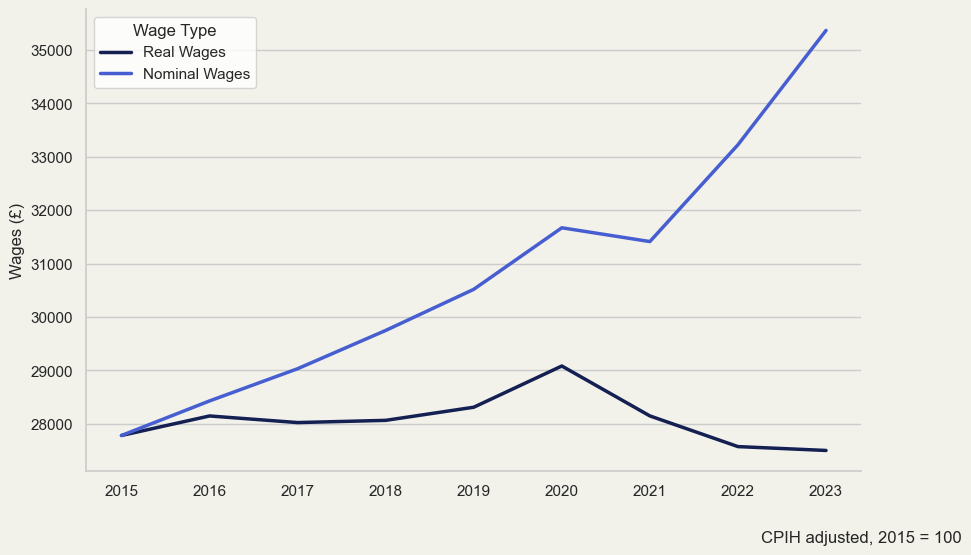

In [2297]:
# Calculate the average median salary across all local authorities for each year
average_salary = long_resident_CPIH.groupby('Year')['adjusted_salary'].mean().reset_index()
average_salary_nonadjusted = long_resident_CPIH.groupby('Year')['Median_Salary'].mean().reset_index()

# Set the style and context for the plot
sns.set(style="whitegrid")

# Create a figure with specified size
plt.figure(figsize=(10, 6))

# Set plot and panel background colors
plt.gca().set_facecolor('#f2f2eb')
plt.gcf().set_facecolor('#f2f2eb')

# Plot the adjusted (real wages) and nonadjusted (nominal wages) salaries with thicker lines
sns.lineplot(data=average_salary, x='Year', y='adjusted_salary', color='#141F52', label='Real Wages', linewidth=2.5)
sns.lineplot(data=average_salary_nonadjusted, x='Year', y='Median_Salary', color='#475ED1', label='Nominal Wages', linewidth=2.5)

# Customize the plot
plt.title('', loc='left', fontsize=16, fontweight='bold')
plt.xlabel('')  # Remove x-axis label
plt.ylabel('Wages (£)')  # Update y-axis label to include £
plt.legend(title='Wage Type')

# Add a caption below the plot
plt.figtext(x=0.80, y=0, s='CPIH adjusted, 2015 = 100', fontsize=12, ha='left', va='center')

# Remove the spines (the lines creating a box around the plot)
sns.despine()

# Remove x grid lines only
plt.grid(axis='x', visible=False)

# Show the plot
plt.show()

In this section I calculate if wages were above 2020 levels and how many were there

In [2298]:
# Filter for 2020 and 2023
salaries_2020 = long_resident_CPIH[long_resident_CPIH['Year'] == 2020][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2020'})
salaries_2023 = long_resident_CPIH[long_resident_CPIH['Year'] == 2023][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2023'})

#  Merge the DataFrames on LA
merged_salaries = salaries_2020.merge(salaries_2023, on='Local_Authority')

#  Compare adjusted_salary for 2023 against 2020 for each LA
merged_salaries['is_higher_or_equal_2023'] = merged_salaries['adjusted_salary_2023'] >= merged_salaries['adjusted_salary_2020']

# Count the LAs that meet the condition
number_of_LAs_meeting_condition = merged_salaries['is_higher_or_equal_2023'].sum()

print(f"Number of local authorities with their 2023 salaries at the level of or higher than in 2020: {number_of_LAs_meeting_condition}")

Number of local authorities with their 2023 salaries at the level of or higher than in 2020: 39


In [2299]:
# Filter for 2020 and 2022
salaries_2020 = long_resident_CPIH[long_resident_CPIH['Year'] == 2020][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2020'})
salaries_2022 = long_resident_CPIH[long_resident_CPIH['Year'] == 2022][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2022'})

# S Merge the DataFrames on LA
merged_salaries = salaries_2020.merge(salaries_2022, on='Local_Authority')

# Compare adjusted_salary for 2022 against 2020 for each LA
merged_salaries['is_higher_or_equal_2022'] = merged_salaries['adjusted_salary_2022'] >= merged_salaries['adjusted_salary_2020']

# Count the LAs that meet the condition
number_of_LAs_meeting_condition = merged_salaries['is_higher_or_equal_2022'].sum()

print(f"Number of local authorities with their 2022 salaries at the level of or higher than in 2020: {number_of_LAs_meeting_condition}")

Number of local authorities with their 2022 salaries at the level of or higher than in 2020: 53


In [2300]:
#  Filter for 2020 and 2021
salaries_2020 = long_resident_CPIH[long_resident_CPIH['Year'] == 2020][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2020'})
salaries_2021 = long_resident_CPIH[long_resident_CPIH['Year'] == 2021][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2021'})

#  Merge the DataFrames on LA
merged_salaries = salaries_2020.merge(salaries_2021, on='Local_Authority')

#  Compare adjusted_salary for 2022 against 2020 for each LA
merged_salaries['is_higher_or_equal_2021'] = merged_salaries['adjusted_salary_2021'] >= merged_salaries['adjusted_salary_2020']

#  Count the LAs that meet the condition
number_of_LAs_meeting_condition = merged_salaries['is_higher_or_equal_2021'].sum()

print(f"Number of local authorities with their 2021 salaries at the level of or higher than in 2020: {number_of_LAs_meeting_condition}")

Number of local authorities with their 2021 salaries at the level of or higher than in 2020: 97


In [2301]:
merged_salaries.head()

Local_Authority  adjusted_salary_2020  adjusted_salary_2021  \
0                  Exeter               28372.0               27046.0   
1  Windsor and Maidenhead               37943.0               34704.0   
2              East Devon               27049.0               26256.0   
3                  Dorset               28346.0               26959.0   
4          Forest of Dean               29749.0               26409.0   

   is_higher_or_equal_2021  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False

In [2302]:
# Load the ONS shapefile for the UK local authorities
shapefile = gpd.read_file('/Users/adamsarissky/Desktop/ERP/shapefiles LA districts')
print(shapefile.columns)

Index(['LAD24CD', 'LAD24NM', 'LAD24NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry'],
      dtype='object')


In [2303]:
# inspect the shapefile
shapefile.head()

LAD24CD               LAD24NM LAD24NMW   BNG_E   BNG_N     LONG      LAT  \
0  E06000001            Hartlepool     None  447161  531473 -1.27017  54.6761   
1  E06000002         Middlesbrough     None  451141  516887 -1.21099  54.5447   
2  E06000003  Redcar and Cleveland     None  464330  519596 -1.00656  54.5675   
3  E06000004      Stockton-on-Tees     None  444940  518179 -1.30664  54.5569   
4  E06000005            Darlington     None  428029  515648 -1.56835  54.5353   

                               GlobalID  \
0  3f58aa35-9ea6-4001-a80f-8aab0e41313f   
1  c5bc1c3e-111f-46db-8e41-362fbbc78d30   
2  29afa1cb-8719-44c2-9906-38bc7bae2981   
3  8ebb86c0-86bb-466e-ae7e-a832eeb755ff   
4  bf2173db-02e1-4b58-9617-e775100f58ec   

                                            geometry  
0  POLYGON ((448964.105 536757.184, 448986.025 53...  
1  POLYGON ((451894.299 521145.303, 453997.697 51...  
2  POLYGON ((478232.947 518788.803, 477689.303 51...  
3  POLYGON ((452243.536 526335.188, 451711.300 52...  
4  POLYGON ((436388.002 522354.197, 437351.702 52...

In [2304]:
# forward fill data to see if it is missing values. 
salary_data = long_resident_CPIH
salary_data['Median_Salary'] = salary_data['Median_Salary'].ffill()
salary_data['adjusted_salary'] = salary_data['adjusted_salary'].ffill()



In [2305]:
salary_data.isnull().sum()

Year               0
Local_Authority    0
Median_Salary      0
CPIH index         0
adjusted_salary    0
dtype: int64

In [2306]:
merged_salaries.isnull().sum()

Local_Authority            0
adjusted_salary_2020       6
adjusted_salary_2021       6
is_higher_or_equal_2021    0
dtype: int64

In [2307]:
salaries_2020.head()

Local_Authority  adjusted_salary_2020
1760                  Exeter               28372.0
1761  Windsor and Maidenhead               37943.0
1762              East Devon               27049.0
1763                  Dorset               28346.0
1764          Forest of Dean               29749.0

In [2308]:
# calculate higher salaries in 2022

# Filter for 2020 and 2022
salaries_2022 = long_resident_CPIH[long_resident_CPIH['Year'] == 2022][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2022'})

#  Merge the DataFrames on LA
merged_salaries = merged_salaries.merge(salaries_2022, on='Local_Authority')

# Compare adjusted_salary for 2024 against 2020 for each LA
merged_salaries['is_higher_or_equal_2022'] = merged_salaries['adjusted_salary_2022'] >= merged_salaries['adjusted_salary_2020']
merged = shapefile.set_index('LAD24NM').join(merged_salaries.set_index('Local_Authority'))


In [2309]:
# calculate higher salaries in 2023

# Filter for 2020 and 2022
salaries_2023 = long_resident_CPIH[long_resident_CPIH['Year'] == 2023][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2023'})

#  Merge the DataFrames on LA
merged_salaries = merged_salaries.merge(salaries_2023, on='Local_Authority')

# Compare adjusted_salary for 2024 against 2020 for each LA
merged_salaries['is_higher_or_equal_2023'] = merged_salaries['adjusted_salary_2023'] >= merged_salaries['adjusted_salary_2020']
merged = shapefile.set_index('LAD24NM').join(merged_salaries.set_index('Local_Authority'))

In [2310]:
merged_salaries.head()

Local_Authority  adjusted_salary_2020  adjusted_salary_2021  \
0                  Exeter               28372.0               27046.0   
1  Windsor and Maidenhead               37943.0               34704.0   
2              East Devon               27049.0               26256.0   
3                  Dorset               28346.0               26959.0   
4          Forest of Dean               29749.0               26409.0   

   is_higher_or_equal_2021  adjusted_salary_2022  is_higher_or_equal_2022  \
0                    False               26348.0                    False   
1                    False               30949.0                    False   
2                    False               22613.0                    False   
3                    False               25929.0                    False   
4                    False               32518.0                     True   

   adjusted_salary_2023  is_higher_or_equal_2023  
0               25526.0                    False  
1               32102.0                    False  
2               23484.0                    False  
3               26771.0                    False  
4               29781.0                     True

In [2311]:
# Merge the DataFrames on LA
# merged_salaries = merged_salaries.merge(salaries_2021, on='Local_Authority')

In [2312]:
merged_salaries.head()

Local_Authority  adjusted_salary_2020  adjusted_salary_2021  \
0                  Exeter               28372.0               27046.0   
1  Windsor and Maidenhead               37943.0               34704.0   
2              East Devon               27049.0               26256.0   
3                  Dorset               28346.0               26959.0   
4          Forest of Dean               29749.0               26409.0   

   is_higher_or_equal_2021  adjusted_salary_2022  is_higher_or_equal_2022  \
0                    False               26348.0                    False   
1                    False               30949.0                    False   
2                    False               22613.0                    False   
3                    False               25929.0                    False   
4                    False               32518.0                     True   

   adjusted_salary_2023  is_higher_or_equal_2023  
0               25526.0                    False  
1               32102.0                    False  
2               23484.0                    False  
3               26771.0                    False  
4               29781.0                     True

In [2313]:

# Compare adjusted_salary for 2024 against 2020 for each LA
merged_salaries['is_higher_or_equal_2021'] = merged_salaries['adjusted_salary_2021'] >= merged_salaries['adjusted_salary_2020']
merged = shapefile.set_index('LAD24NM').join(merged_salaries.set_index('Local_Authority'))

In [2314]:
merged_salaries.head()

Local_Authority  adjusted_salary_2020  adjusted_salary_2021  \
0                  Exeter               28372.0               27046.0   
1  Windsor and Maidenhead               37943.0               34704.0   
2              East Devon               27049.0               26256.0   
3                  Dorset               28346.0               26959.0   
4          Forest of Dean               29749.0               26409.0   

   is_higher_or_equal_2021  adjusted_salary_2022  is_higher_or_equal_2022  \
0                    False               26348.0                    False   
1                    False               30949.0                    False   
2                    False               22613.0                    False   
3                    False               25929.0                    False   
4                    False               32518.0                     True   

   adjusted_salary_2023  is_higher_or_equal_2023  
0               25526.0                    False  
1               32102.0                    False  
2               23484.0                    False  
3               26771.0                    False  
4               29781.0                     True

In [2315]:
# new dataset
columns_to_remove = ['adjusted_salary_2020', 'adjusted_salary_2021', 'adjusted_salary_2022', 'adjusted_salary_2023']
merged_salaries = merged_salaries.drop(columns=columns_to_remove)

In [2316]:
# inspect dataset 
merged_salaries.head()

Local_Authority  is_higher_or_equal_2021  is_higher_or_equal_2022  \
0                  Exeter                    False                    False   
1  Windsor and Maidenhead                    False                    False   
2              East Devon                    False                    False   
3                  Dorset                    False                    False   
4          Forest of Dean                    False                     True   

   is_higher_or_equal_2023  
0                    False  
1                    False  
2                    False  
3                    False  
4                     True

In [2317]:
# inspect the data
print("Columns in merged_salaries:", merged_salaries.columns)


Columns in merged_salaries: Index(['Local_Authority', 'is_higher_or_equal_2021', 'is_higher_or_equal_2022',
       'is_higher_or_equal_2023'],
      dtype='object')


In [2318]:
# Sankey Chart 

# Create a list of transitions
transitions = []
years = ['is_higher_or_equal_2021', 'is_higher_or_equal_2022', 'is_higher_or_equal_2023']
for i in range(len(years) - 1):
    current_year = years[i]
    next_year = years[i + 1]
    transition_counts = merged_salaries.groupby([current_year, next_year]).size().reset_index(name='count')
    for _, row in transition_counts.iterrows():
        transitions.append([current_year, next_year, row[current_year], row[next_year], row['count']])

# Create source, target, and value lists for Sankey diagram
source = []
target = []
value = []
labels = ['Higher in 2021', 'Lower in 2021', 'Higher in 2022', 'Lower in 2022', 'Higher in 2023', 'Lower in 2023']
label_map = {label: idx for idx, label in enumerate(labels)}

for transition in transitions:
    src_year = int(transition[0].split('_')[-1])
    tgt_year = int(transition[1].split('_')[-1])
    src_label = f"Higher in {src_year}" if transition[2] else f"Lower in {src_year}"
    tgt_label = f"Higher in {tgt_year}" if transition[3] else f"Lower in {tgt_year}"
    source.append(label_map[src_label])
    target.append(label_map[tgt_label])
    value.append(transition[4])

# Define colors for nodes
node_colors = ["#1F2E7A" if 'Higher' in label else "#F6423C" for label in labels]

# Define colors for links
link_colors = []
for src in source:
    if 'Higher' in labels[src]:
        link_colors.append('rgba(31, 46, 122, 0.5)')  # Blue for higher
    else:
        link_colors.append('rgba(246, 66, 60, 0.5)')  # Red for lower

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hoverinfo='all'
    )
)])
fig.update_layout(
    title_text="",
    title_font=dict(size=30, color='black', family='Arial'),
    font_size=12,
    annotations=[dict(
        text="",
        x=-0.05,
        y=1.105,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(size=12, color='black', family='Arial')
    )],
    paper_bgcolor='#f2f2eb',
    plot_bgcolor='#f2f2eb'
)

import plotly.io as pio
pio.renderers.default = 'notebook'
fig.show()

In [2319]:
# counts of resilience indicator 
merged_salaries['resilience_indicator'] = merged_salaries[['is_higher_or_equal_2021', 'is_higher_or_equal_2022', 'is_higher_or_equal_2023']].sum(axis=1)

In [2320]:
# show the counts of reslience indicator
merged_salaries['resilience_indicator'].value_counts()

resilience_indicator
0    217
1     77
2     43
3     15
Name: count, dtype: int64

In [2321]:
# join with a shapefile for geo viz
merged_resilience = shapefile.set_index('LAD24NM').join(merged_salaries.set_index('Local_Authority'))


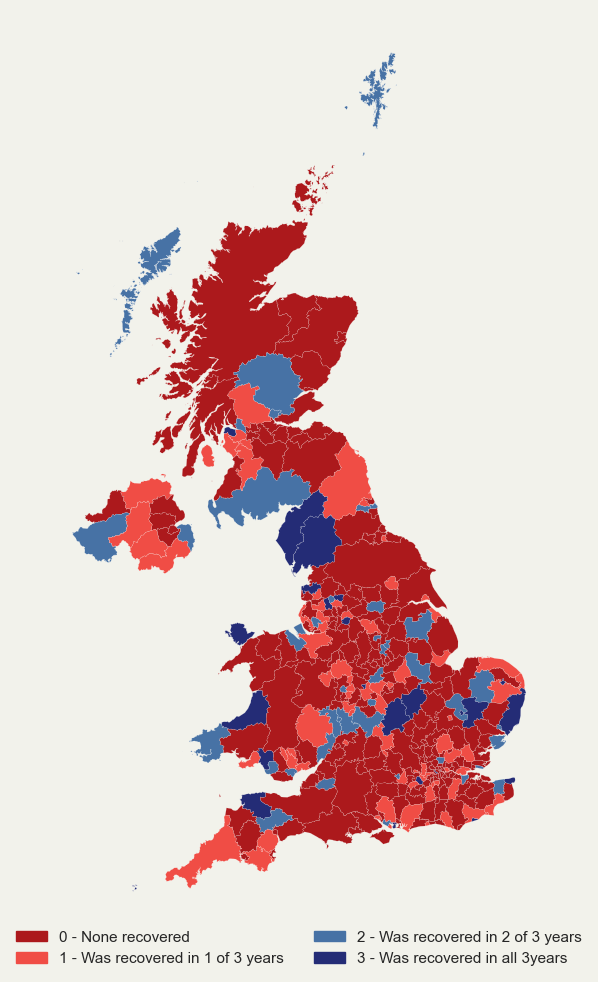

In [2322]:
# geo viz chart for recovery

# Update colormap to accommodate 5 categories now (0 to 4)
colors_list = ['#ac191c', '#f04d45', '#4772a5', '#242c76']  # Directly transitions from red to blue
cmap = LinearSegmentedColormap.from_list('RedBlue', colors_list, N=4)

# Adjust normalization for 5 categories, from 0 to 4
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], ncolors=5)

# Apply the colormap to the 'resilience_indicator' column to get the colors
colors = cmap(norm(merged_resilience['resilience_indicator']))

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set the background color
fig.patch.set_facecolor('#f2f2eb')
ax.set_facecolor('#f2f2eb')

# Plot the data
merged_resilience.plot(ax=ax, color=colors, linewidth=0.1)

# Remove all axis lines
ax.axis('off')

# Create a custom legend to reflect 5 categories
legend_labels = [
    mpatches.Patch(color=cmap(0), label='0 - None recovered'),
    mpatches.Patch(color=cmap(1), label='1 - Was recovered in 1 of 3 years'),
    mpatches.Patch(color=cmap(2), label='2 - Was recovered in 2 of 3 years'),
    mpatches.Patch(color=cmap(3), label='3 - Was recovered in all 3years')
]

# Add the legend
legend = ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)

# Add a well-formatted headline and subtitle
plt.suptitle('', 
             fontsize=20, fontweight='bold', color='#333333', ha='left', x=0.3, y=0.9)

# Show the plot
plt.show()

In [2323]:
# change the true flase to 1 and 0
long_data = merged_salaries.replace({False: 0, True: 1})

/var/folders/kh/kvrs5sp15tx0d3k647zd9b540000gn/T/ipykernel_33340/758997833.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [2324]:
# inspect data
long_data.head()

Local_Authority  is_higher_or_equal_2021  is_higher_or_equal_2022  \
0                  Exeter                        0                        0   
1  Windsor and Maidenhead                        0                        0   
2              East Devon                        0                        0   
3                  Dorset                        0                        0   
4          Forest of Dean                        0                        1   

   is_higher_or_equal_2023  resilience_indicator  
0                        0                     0  
1                        0                     0  
2                        0                     0  
3                        0                     0  
4                        1                     2

In [2325]:
# drop resilience indicator
long_data = long_data.drop(columns=['resilience_indicator'])

In [2326]:
# melt the data
long_data = pd.melt(long_data, id_vars=['Local_Authority'], var_name='year', value_name='recovered')


In [2327]:
# year column change
long_data['year'] = long_data['year'].str.extract(r'(\d{4})')

In [2328]:
# make resilience indicator data
resilience_indicator = merged_salaries[['Local_Authority', 'resilience_indicator']]

In [2329]:
# inspet
resilience_indicator.head()

Local_Authority  resilience_indicator
0                  Exeter                     0
1  Windsor and Maidenhead                     0
2              East Devon                     0
3                  Dorset                     0
4          Forest of Dean                     2

In [2330]:
# inspect data
long_resident_CPIH.head()

Year        Local_Authority  Median_Salary  CPIH index  adjusted_salary
0  2015                Babergh        27757.0       100.0          27757.0
1  2015               Waverley        37625.0       100.0          37625.0
2  2015    Vale of White Horse        32035.0       100.0          32035.0
3  2015        Tunbridge Wells        35133.0       100.0          35133.0
4  2015  Tonbridge and Malling        34995.0       100.0          34995.0

In [2331]:
# make live copy
data = long_resident_CPIH

In [2332]:
# check
data.head()

Year        Local_Authority  Median_Salary  CPIH index  adjusted_salary
0  2015                Babergh        27757.0       100.0          27757.0
1  2015               Waverley        37625.0       100.0          37625.0
2  2015    Vale of White Horse        32035.0       100.0          32035.0
3  2015        Tunbridge Wells        35133.0       100.0          35133.0
4  2015  Tonbridge and Malling        34995.0       100.0          34995.0

In [2333]:
# make data for TDA
TDA_data = data.pivot(index='Local_Authority', columns='Year', values='adjusted_salary')
TDA_data.columns = [f'salaries_{col}' for col in TDA_data.columns]
TDA_data.reset_index(inplace=True)


In [2334]:
# get resilience indicator back
TDA_data = TDA_data.merge(resilience_indicator, on='Local_Authority')

In [2335]:
# inspect
TDA_data.head()

Local_Authority  salaries_2015  salaries_2016  salaries_2017  salaries_2018  \
0   Aberdeen City        30151.0        29059.0        27510.0        28141.0   
1   Aberdeenshire        30535.0        29591.0        28411.0        29129.0   
2            Adur        25227.0        24401.0        23675.0        25256.0   
3    Amber Valley        26694.0        27556.0        28987.0        28015.0   
4           Angus        26471.0        27233.0        26572.0        27408.0   

   salaries_2019  salaries_2020  salaries_2021  salaries_2022  salaries_2023  \
0        28224.0        28113.0        26848.0        26689.0        27335.0   
1        30185.0        31194.0        28747.0        28895.0        28230.0   
2        25899.0        27778.0        25787.0        26851.0        25659.0   
3        27460.0        30867.0        28126.0        25343.0        25477.0   
4        27211.0        27418.0        26939.0        26076.0        26653.0   

   resilience_indicator  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [2336]:
# change true false to 0 1 
merged_salaries['is_higher_or_equal_2021'] = merged_salaries['is_higher_or_equal_2021'].astype(int)
merged_salaries['is_higher_or_equal_2022'] = merged_salaries['is_higher_or_equal_2022'].astype(int)
merged_salaries['is_higher_or_equal_2023'] = merged_salaries['is_higher_or_equal_2023'].astype(int)
merged_salaries.drop(columns=['resilience_indicator'], inplace=True)


In [2337]:
# get yearly return data
TDA_data = TDA_data.merge(merged_salaries, on='Local_Authority')

# TDA-BM of real wage recovery on resilience indicator 

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



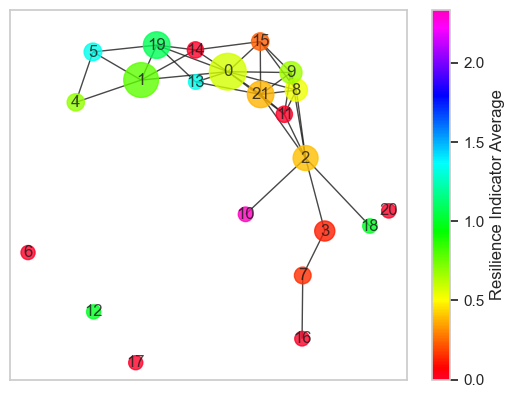

In [2338]:
# make TDA plot

bmx1 = TDA_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(TDA_data['resilience_indicator'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='resilience_indicator', color_palette=hsvp, colorbar=True, colorbar_label="Resilience Indicator Average",
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))

plt.grid(False)  # This removes gridlines

# Show the plot
plt.show()

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



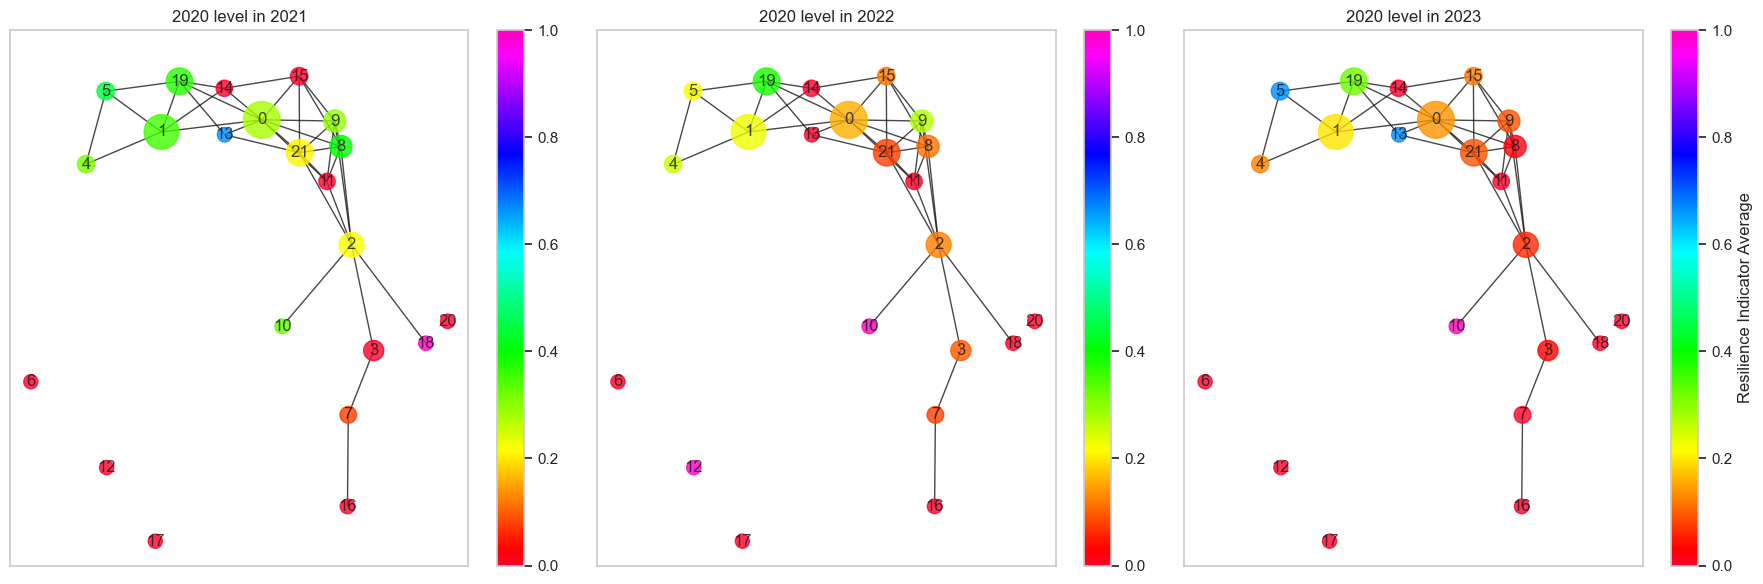

In [2339]:
# TDA plot by yearly resilience

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
bmx1 = TDA_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2021'])
bm1 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2021', color_palette=hsvp, colorbar=True, 
                  pos=nx.spring_layout(bm1.Graph, k=0.6, seed=55), ax=axes[0])
axes[0].set_title('2020 level in 2021')
axes[0].grid(False)  # This removes gridlines from the first subplot


# Plot 2
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2022'])
bm1 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2022', color_palette=hsvp, colorbar=True, 
                  pos=nx.spring_layout(bm1.Graph, k=0.6, seed=55), ax=axes[1])
axes[1].set_title('2020 level in 2022')
axes[1].grid(False)  # This removes gridlines from the first subplot


# Plot 3
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2023'])
bm1 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2023', color_palette=hsvp, colorbar=True, colorbar_label="Resilience Indicator Average", 
                  pos=nx.spring_layout(bm1.Graph, k=0.6, seed=55), ax=axes[2])
axes[2].set_title('2020 level in 2023')

# Adjust layout
plt.grid(False)  # This removes gridlines
plt.tight_layout()
plt.show()

In [2340]:
# save as points
pb1 = bm1.points_and_balls()

In [2341]:
# inspect
pb1

point  ball
0        0     0
1        1     0
2        2     0
3        3     0
4        4     0
..     ...   ...
766    328    21
767    329    21
768    334    21
769    335    21
770    338    21

[771 rows x 2 columns]

In [2342]:
# get index to TDA
TDA_data['point'] = TDA_data.index

In [2343]:
# get balls
TDA_data = TDA_data.merge(pb1, on='point')

In [2344]:
# inspect
TDA_data.head()

Local_Authority  salaries_2015  salaries_2016  salaries_2017  salaries_2018  \
0   Aberdeen City        30151.0        29059.0        27510.0        28141.0   
1   Aberdeenshire        30535.0        29591.0        28411.0        29129.0   
2   Aberdeenshire        30535.0        29591.0        28411.0        29129.0   
3   Aberdeenshire        30535.0        29591.0        28411.0        29129.0   
4   Aberdeenshire        30535.0        29591.0        28411.0        29129.0   

   salaries_2019  salaries_2020  salaries_2021  salaries_2022  salaries_2023  \
0        28224.0        28113.0        26848.0        26689.0        27335.0   
1        30185.0        31194.0        28747.0        28895.0        28230.0   
2        30185.0        31194.0        28747.0        28895.0        28230.0   
3        30185.0        31194.0        28747.0        28895.0        28230.0   
4        30185.0        31194.0        28747.0        28895.0        28230.0   

   resilience_indicator  is_higher_or_equal_2021  is_higher_or_equal_2022  \
0                     0                        0                        0   
1                     0                        0                        0   
2                     0                        0                        0   
3                     0                        0                        0   
4                     0                        0                        0   

   is_higher_or_equal_2023  point  ball  
0                        0      0     0  
1                        0      1     0  
2                        0      1     8  
3                        0      1     9  
4                        0      1    15

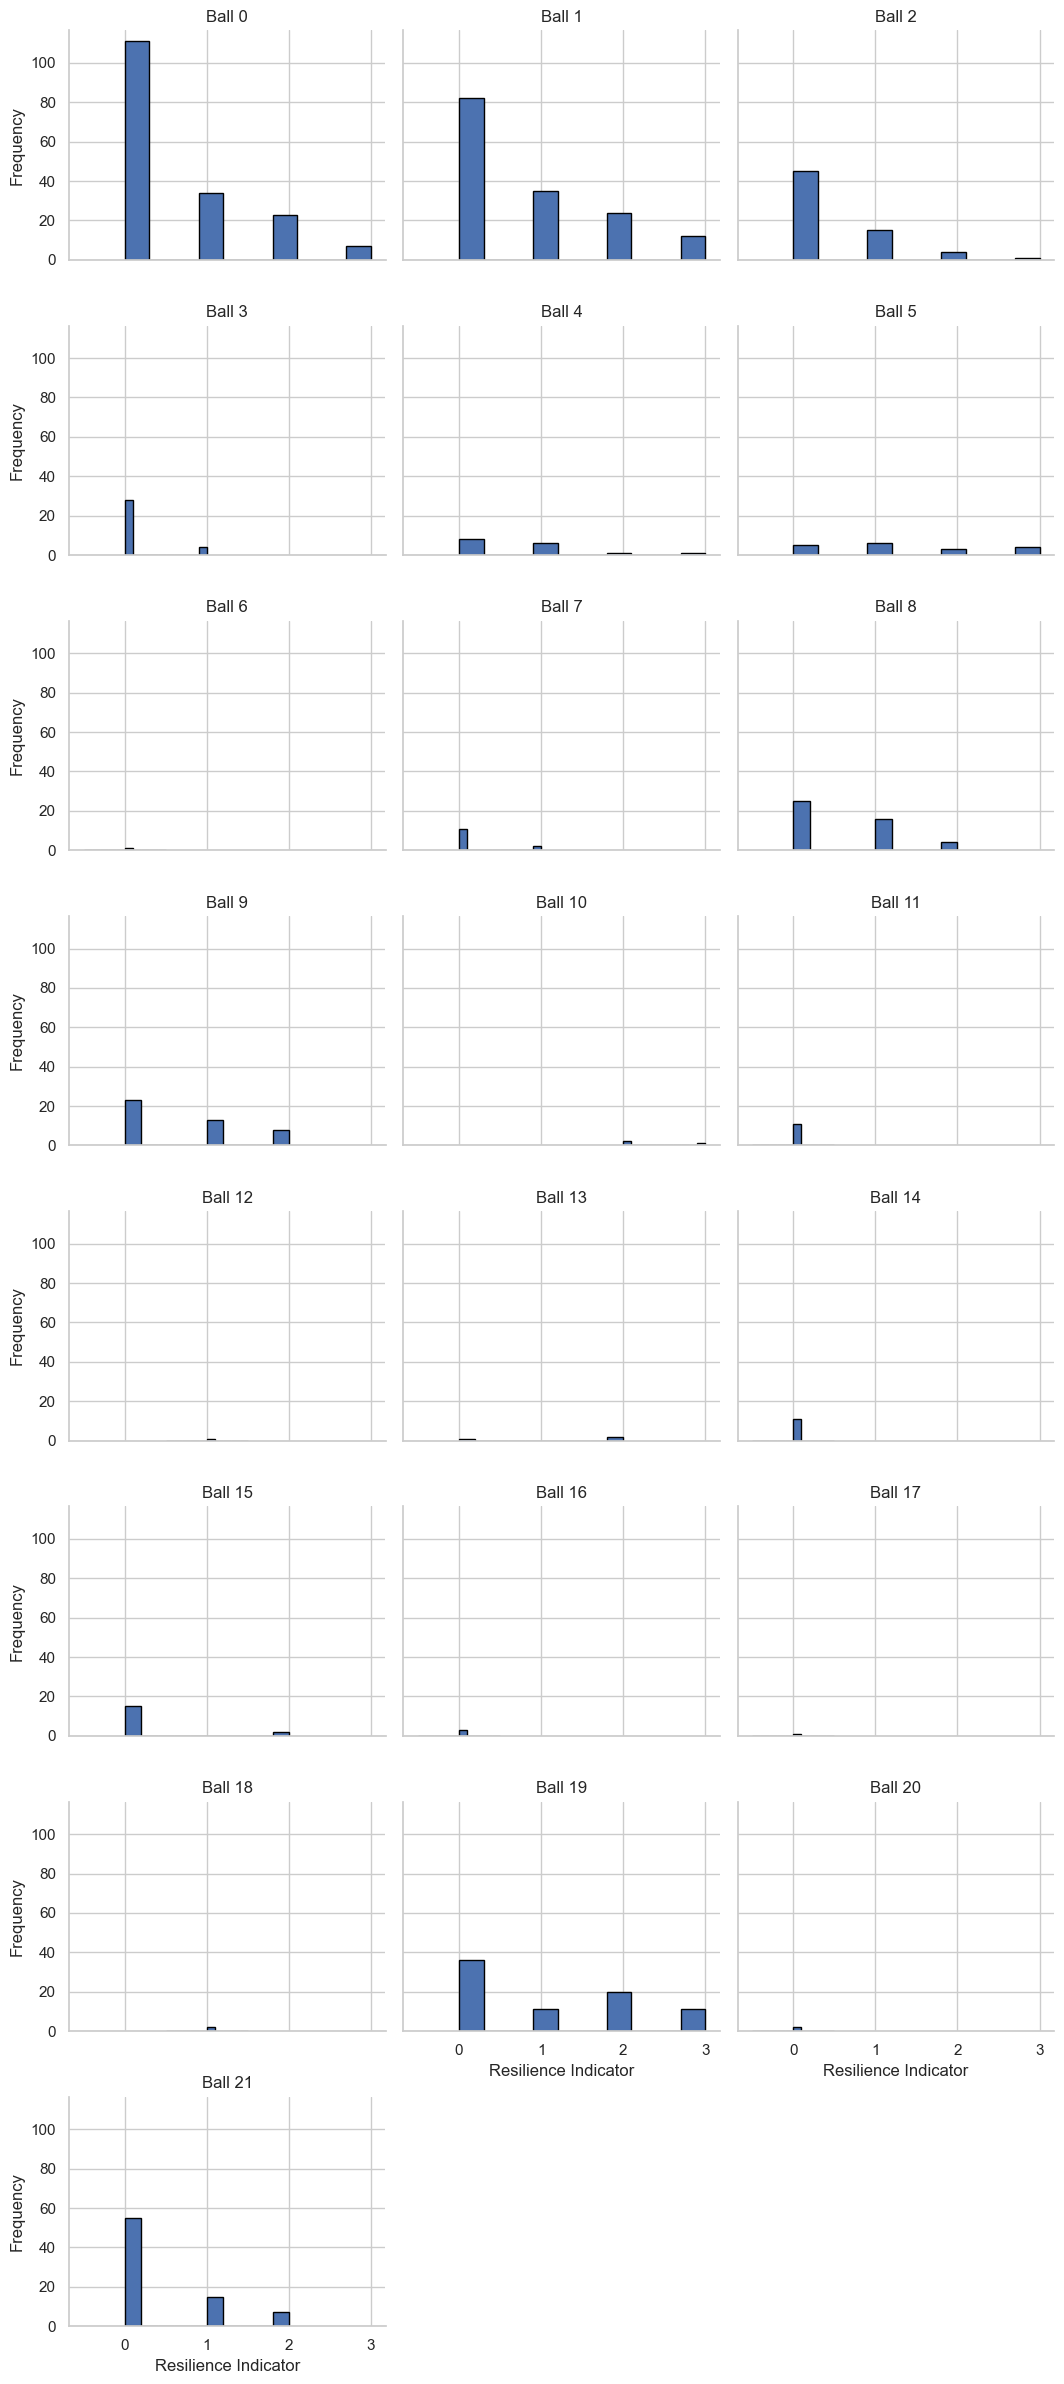

In [2345]:
# inspect the distribution of resilience indicator in each ball

g = sns.FacetGrid(TDA_data, col='ball', col_wrap=3, height=3, aspect=1.2)

# Function to plot histogram for each ball
def plot_histogram(data, **kwargs):
    plt.hist(data['resilience_indicator'], bins=10, edgecolor='black')

# Map the plotting function to the FacetGrid
g.map_dataframe(plot_histogram)

# Set titles and labels
g.set_titles(col_template='Ball {col_name}')
g.set_axis_labels('Resilience Indicator', 'Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()

# Read-wage Recovery trajectories

In [2346]:
# pivot longer data

TDA_data = pd.melt(TDA_data, 
                    id_vars=['Local_Authority', 'resilience_indicator', 'point', 'ball'], 
                    value_vars=['salaries_2015', 'salaries_2016', 'salaries_2017', 'salaries_2018', 'salaries_2019', 'salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023'], 
                    var_name='Year', 
                    value_name='salaries')

# Extract the year from the column names
TDA_data['Year'] = TDA_data['Year'].str.extract('(\d+)', expand=False)

# Display the first few rows to verify the change
TDA_data.head()

Local_Authority  resilience_indicator  point  ball  Year  salaries
0   Aberdeen City                     0      0     0  2015   30151.0
1   Aberdeenshire                     0      1     0  2015   30535.0
2   Aberdeenshire                     0      1     8  2015   30535.0
3   Aberdeenshire                     0      1     9  2015   30535.0
4   Aberdeenshire                     0      1    15  2015   30535.0

In [2347]:
# only year 2020 and more
TDA_data = TDA_data[TDA_data['Year'].astype(int) >= 2020]

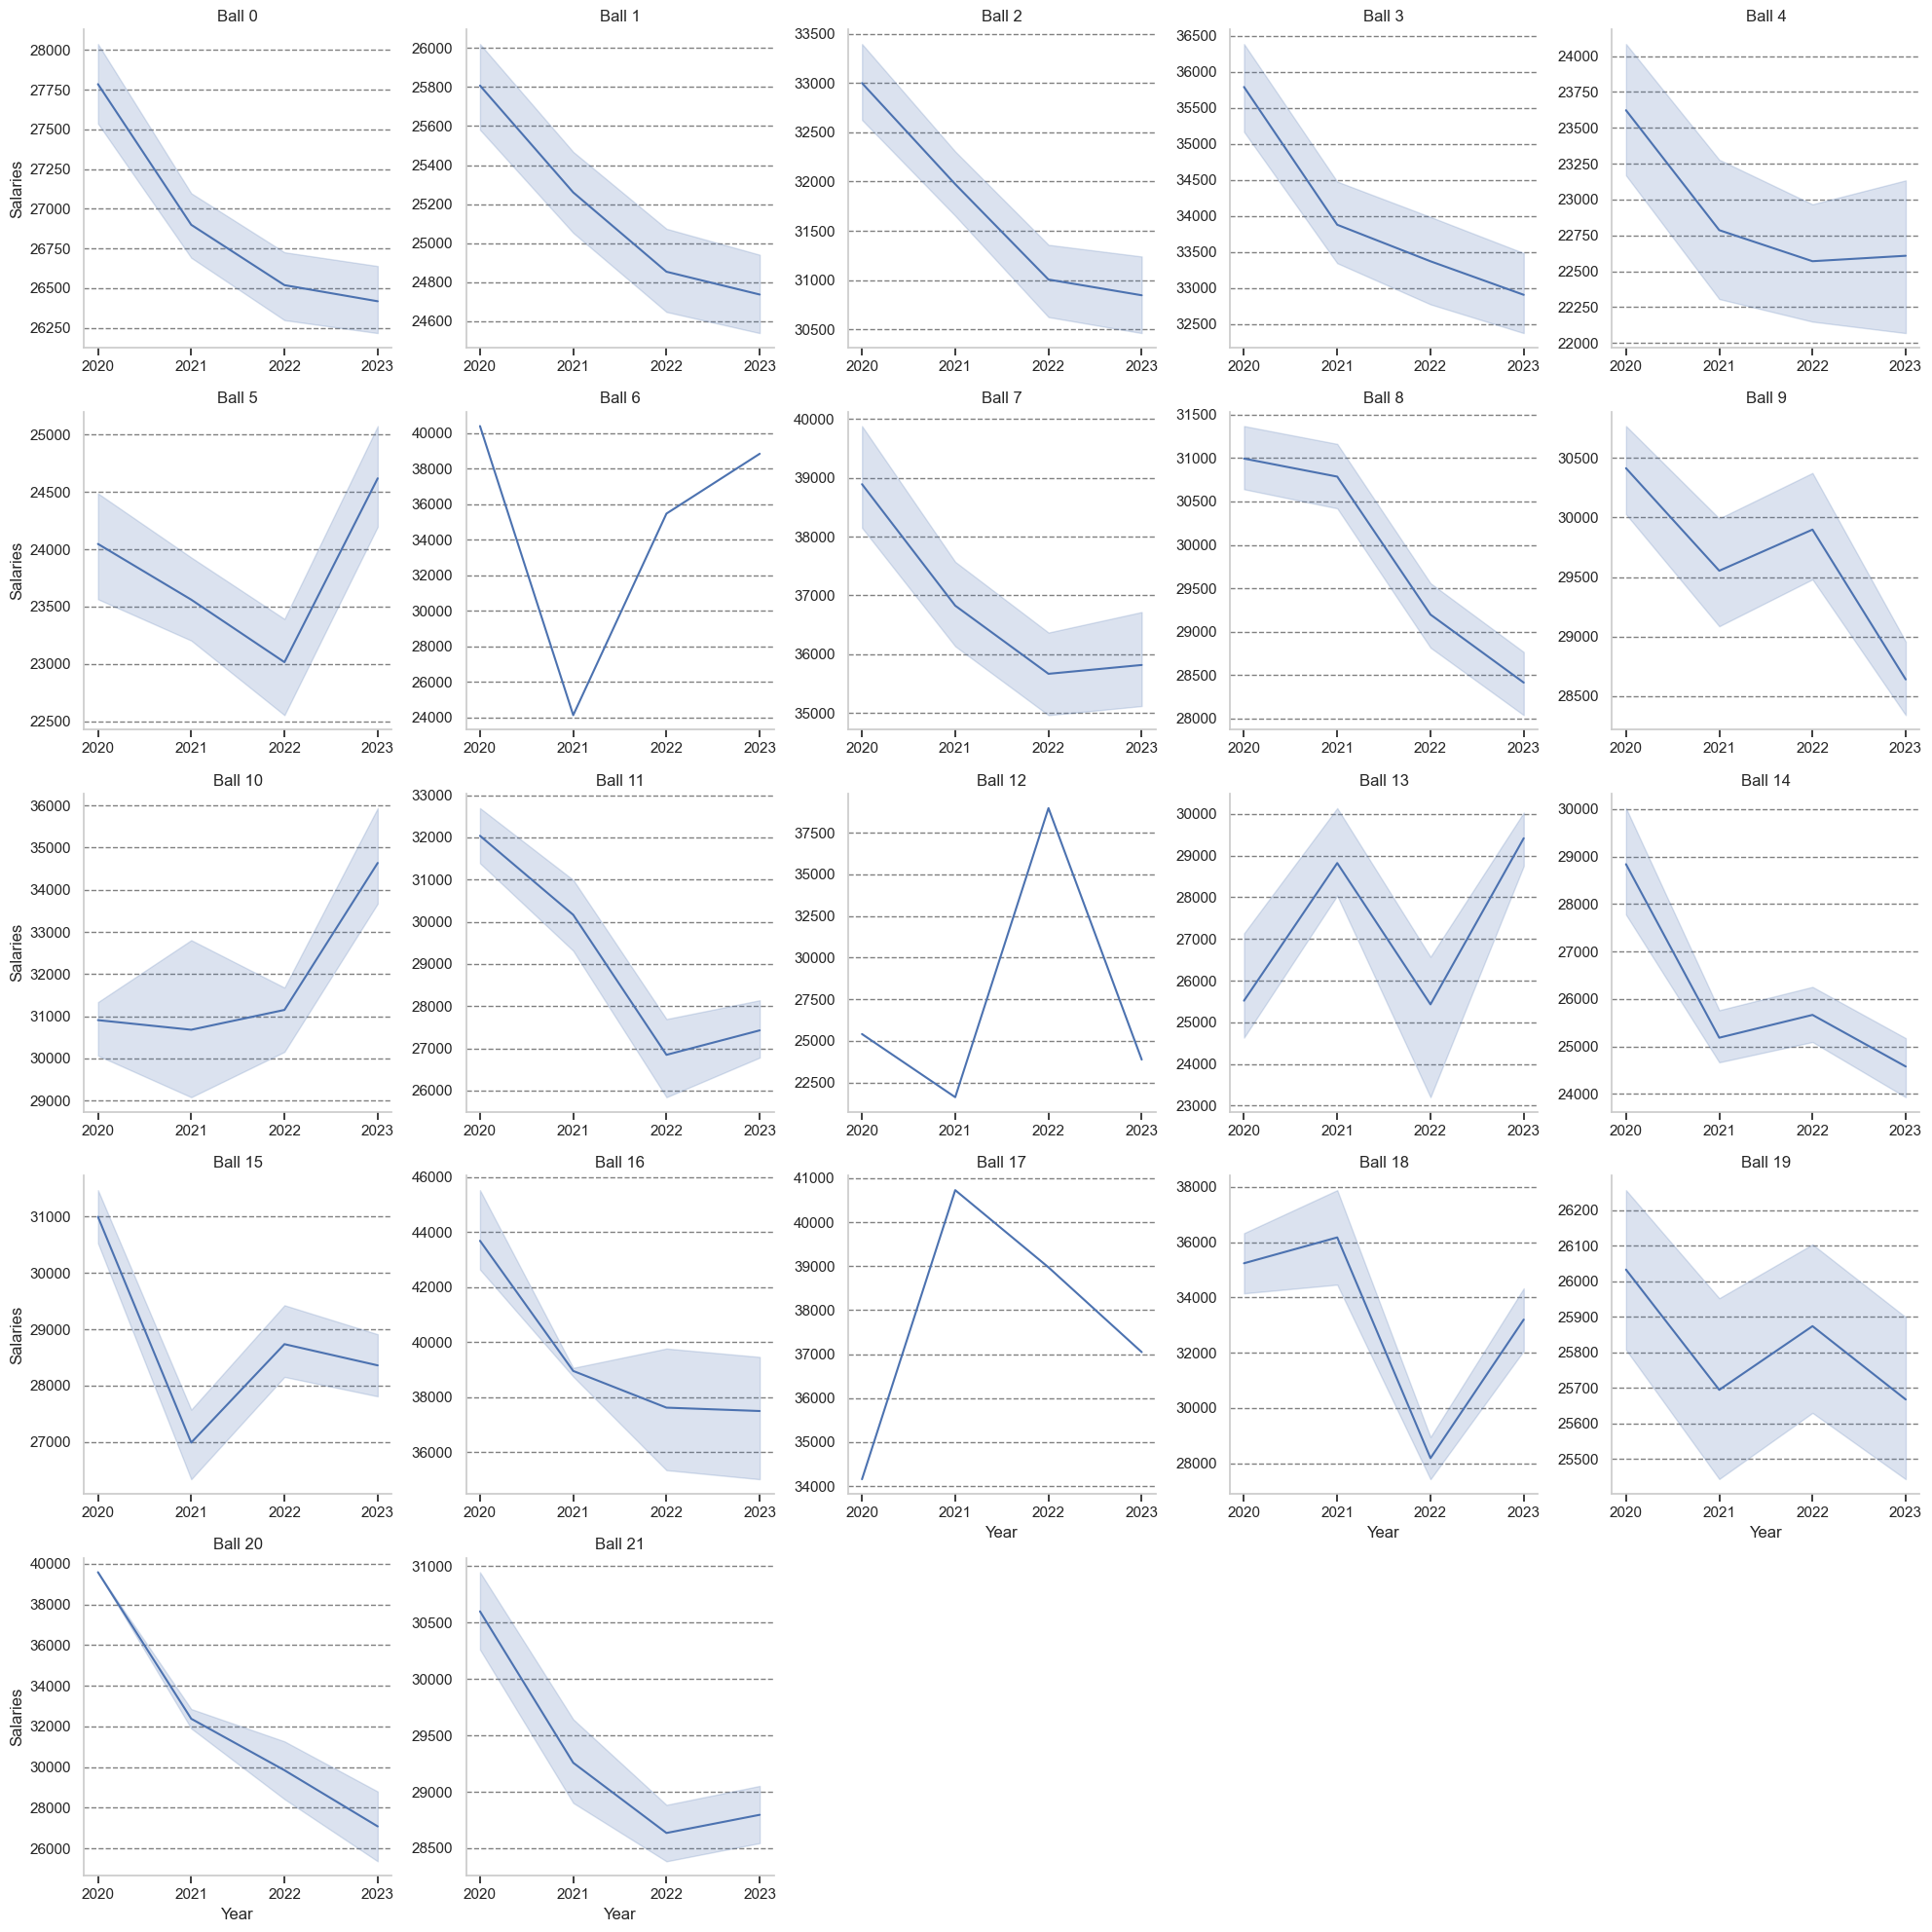

In [2348]:
# look at unique trajectories of data

unique_balls = TDA_data['ball'].unique()

# Convert 'Year' column to categorical type for proper sorting
TDA_data['Year'] = pd.Categorical(TDA_data['Year'], categories=sorted(TDA_data['Year'].unique()), ordered=True)

# Create a line chart for each ball value with 5 charts per row
g = sns.FacetGrid(TDA_data, col='ball', col_wrap=5, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='Year', y='salaries', legend=False)

# Set titles and labels
g.set_titles(col_template='Ball {col_name}')
g.set_axis_labels('Year', 'Salaries')

# Set the year ticks for each subplot and remove only the x-axis grid
years = TDA_data['Year'].unique()
for ax in g.axes.flat:
    ax.set_xticks(years)  # Set x-ticks to unique years
    ax.set_xticklabels(years, rotation=0)  # Rotate x-ticks for better visibility
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)  # Ensure x-ticks are visible
    ax.grid(axis='x', linestyle='')  # Remove the x-axis grid only
    ax.grid(axis='y', linestyle='--', color='gray')  # Make y-axis grid dotted


plt.tight_layout()
plt.show()

In [2349]:
big_geo = TDA_data
big_geo = shapefile.set_index('LAD24NM').join(big_geo.set_index('Local_Authority'))

In [2350]:
# check count of LAs per ball
la_counts = TDA_data.groupby('ball')['Local_Authority'].nunique()
print(la_counts)

ball
0     175
1     153
2      65
3      32
4      16
5      18
6       1
7      13
8      45
9      44
10      3
11     11
12      1
13      3
14     11
15     17
16      3
17      1
18      2
19     78
20      2
21     77
Name: Local_Authority, dtype: int64


In [2351]:
TDA_2023 = TDA_data[TDA_data['Year'] == '2023']
TDA_2023 = TDA_2023.drop(columns=['Year', 'point'])
TDA_2023['Local_Authority'] = TDA_2023['Local_Authority'].astype(str)


In [2352]:
TDA_2023.head()


Local_Authority  resilience_indicator  ball  salaries
6168   Aberdeen City                     0     0   27335.0
6169   Aberdeenshire                     0     0   28230.0
6170   Aberdeenshire                     0     8   28230.0
6171   Aberdeenshire                     0     9   28230.0
6172   Aberdeenshire                     0    15   28230.0

In [2353]:
# get data for only one year to avoid duplicates
# Pivot the dataset wider to create columns indicating ball membership
pivot_df = TDA_2023.pivot_table(index=['Local_Authority', 'resilience_indicator', 'salaries'], 
                          columns='ball', 
                          aggfunc='size', 
                          fill_value=0).reset_index()

# Rename the columns for better clarity
pivot_df.columns.name = None
pivot_df.columns = ['Local_Authority', 'resilience_indicator', 'salaries'] + [f'ball_{col}' for col in pivot_df.columns[3:]]

# Display the pivoted DataFrame
pivot_df

Local_Authority  resilience_indicator  salaries  ball_0  ball_1  ball_2  \
0     Aberdeen City                     0   27335.0       1       0       0   
1     Aberdeenshire                     0   28230.0       1       0       0   
2              Adur                     0   25659.0       1       1       0   
3      Amber Valley                     0   25477.0       1       0       0   
4             Angus                     0   26653.0       1       1       0   
..              ...                   ...       ...     ...     ...     ...   
347         Wrexham                     0   24893.0       1       1       0   
348        Wychavon                     2   26576.0       1       1       0   
349            Wyre                     3   25645.0       1       1       0   
350     Wyre Forest                     0   26576.0       1       1       0   
351            York                     1   25079.0       1       0       0   

     ball_3  ball_4  ball_5  ball_6  ...  ball_12  ball_13  ball_14  ball_15  \
0         0       0       0       0  ...        0        0        0        0   
1         0       0       0       0  ...        0        0        0        1   
2         0       0       0       0  ...        0        0        0        0   
3         0       0       0       0  ...        0        0        0        0   
4         0       0       0       0  ...        0        0        0        0   
..      ...     ...     ...     ...  ...      ...      ...      ...      ...   
347       0       0       0       0  ...        0        0        0        0   
348       0       0       0       0  ...        0        0        0        0   
349       0       0       0       0  ...        0        0        0        0   
350       0       0       0       0  ...        0        0        0        0   
351       0       0       0       0  ...        0        0        0        0   

     ball_16  ball_17  ball_18  ball_19  ball_20  ball_21  
0          0        0        0        0        0        0  
1          0        0        0        0        0        1  
2          0        0        0        1        0        0  
3          0        0        0        0        0        0  
4          0        0        0        1        0        0  
..       ...      ...      ...      ...      ...      ...  
347        0        0        0        1        0        0  
348        0        0        0        1        0        0  
349        0        0        0        1        0        0  
350        0        0        0        1        0        0  
351        0        0        0        0        0        0  

[352 rows x 25 columns]

In [2354]:
# check
pivot_df

Local_Authority  resilience_indicator  salaries  ball_0  ball_1  ball_2  \
0     Aberdeen City                     0   27335.0       1       0       0   
1     Aberdeenshire                     0   28230.0       1       0       0   
2              Adur                     0   25659.0       1       1       0   
3      Amber Valley                     0   25477.0       1       0       0   
4             Angus                     0   26653.0       1       1       0   
..              ...                   ...       ...     ...     ...     ...   
347         Wrexham                     0   24893.0       1       1       0   
348        Wychavon                     2   26576.0       1       1       0   
349            Wyre                     3   25645.0       1       1       0   
350     Wyre Forest                     0   26576.0       1       1       0   
351            York                     1   25079.0       1       0       0   

     ball_3  ball_4  ball_5  ball_6  ...  ball_12  ball_13  ball_14  ball_15  \
0         0       0       0       0  ...        0        0        0        0   
1         0       0       0       0  ...        0        0        0        1   
2         0       0       0       0  ...        0        0        0        0   
3         0       0       0       0  ...        0        0        0        0   
4         0       0       0       0  ...        0        0        0        0   
..      ...     ...     ...     ...  ...      ...      ...      ...      ...   
347       0       0       0       0  ...        0        0        0        0   
348       0       0       0       0  ...        0        0        0        0   
349       0       0       0       0  ...        0        0        0        0   
350       0       0       0       0  ...        0        0        0        0   
351       0       0       0       0  ...        0        0        0        0   

     ball_16  ball_17  ball_18  ball_19  ball_20  ball_21  
0          0        0        0        0        0        0  
1          0        0        0        0        0        1  
2          0        0        0        1        0        0  
3          0        0        0        0        0        0  
4          0        0        0        1        0        0  
..       ...      ...      ...      ...      ...      ...  
347        0        0        0        1        0        0  
348        0        0        0        1        0        0  
349        0        0        0        1        0        0  
350        0        0        0        1        0        0  
351        0        0        0        0        0        0  

[352 rows x 25 columns]

In [2355]:
# merge with shapefile
merged = shapefile.set_index('LAD24NM').join(pivot_df.set_index('Local_Authority'))

In [2356]:
# inspect
merged.head()

LAD24CD LAD24NMW   BNG_E   BNG_N     LONG      LAT  \
LAD24NM                                                                      
Hartlepool            E06000001     None  447161  531473 -1.27017  54.6761   
Middlesbrough         E06000002     None  451141  516887 -1.21099  54.5447   
Redcar and Cleveland  E06000003     None  464330  519596 -1.00656  54.5675   
Stockton-on-Tees      E06000004     None  444940  518179 -1.30664  54.5569   
Darlington            E06000005     None  428029  515648 -1.56835  54.5353   

                                                  GlobalID  \
LAD24NM                                                      
Hartlepool            3f58aa35-9ea6-4001-a80f-8aab0e41313f   
Middlesbrough         c5bc1c3e-111f-46db-8e41-362fbbc78d30   
Redcar and Cleveland  29afa1cb-8719-44c2-9906-38bc7bae2981   
Stockton-on-Tees      8ebb86c0-86bb-466e-ae7e-a832eeb755ff   
Darlington            bf2173db-02e1-4b58-9617-e775100f58ec   

                                                               geometry  \
LAD24NM                                                                   
Hartlepool            POLYGON ((448964.105 536757.184, 448986.025 53...   
Middlesbrough         POLYGON ((451894.299 521145.303, 453997.697 51...   
Redcar and Cleveland  POLYGON ((478232.947 518788.803, 477689.303 51...   
Stockton-on-Tees      POLYGON ((452243.536 526335.188, 451711.300 52...   
Darlington            POLYGON ((436388.002 522354.197, 437351.702 52...   

                      resilience_indicator  salaries  ...  ball_12  ball_13  \
LAD24NM                                               ...                     
Hartlepool                             0.0   25257.0  ...      0.0      0.0   
Middlesbrough                          1.0   22819.0  ...      0.0      0.0   
Redcar and Cleveland                   0.0   23552.0  ...      0.0      0.0   
Stockton-on-Tees                       0.0   25498.0  ...      0.0      0.0   
Darlington                             0.0   23764.0  ...      0.0      0.0   

                      ball_14  ball_15  ball_16  ball_17  ball_18  ball_19  \
LAD24NM                                                                      
Hartlepool                0.0      0.0      0.0      0.0      0.0      1.0   
Middlesbrough             0.0      0.0      0.0      0.0      0.0      0.0   
Redcar and Cleveland      0.0      0.0      0.0      0.0      0.0      0.0   
Stockton-on-Tees          0.0      0.0      0.0      0.0      0.0      1.0   
Darlington                0.0      0.0      0.0      0.0      0.0      1.0   

                      ball_20  ball_21  
LAD24NM                                 
Hartlepool                0.0      0.0  
Middlesbrough             0.0      0.0  
Redcar and Cleveland      0.0      0.0  
Stockton-on-Tees          0.0      0.0  
Darlington                0.0      0.0  

[5 rows x 32 columns]

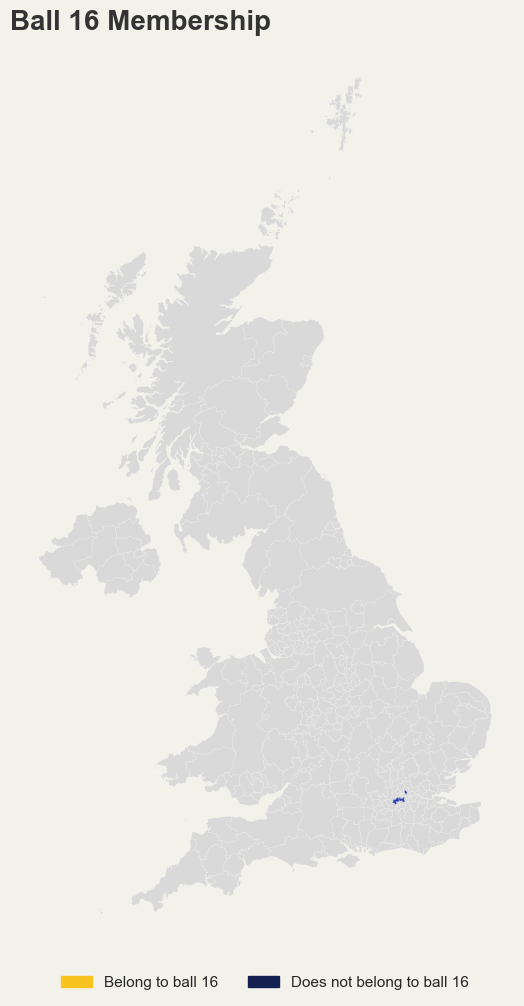

In [2357]:
# visualise ball membership 

# Define a function to map ball values to colors
def get_color(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Apply the function to the 'ball' column to get the colors
colors = merged['ball_16'].apply(get_color)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set the background color
fig.patch.set_facecolor('#f2f2eb')
ax.set_facecolor('#f2f2eb')

# Plot the data
merged.plot(ax=ax, color=colors, linewidth=0.1)

# Remove all axis lines
ax.axis('off')

# Create a custom legend
legend_labels = [mpatches.Patch(color='#F9C31F', label='Belong to ball 16'),
                 mpatches.Patch(color='#141F52', label='Does not belong to ball 16')]
legend = ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)

# Add a well-formatted headline and subtitle
plt.suptitle('Ball 16 Membership', fontsize=20, fontweight='bold', color='#333333', ha='left', x=0.3, y=0.9)

# Show the plot
plt.show()

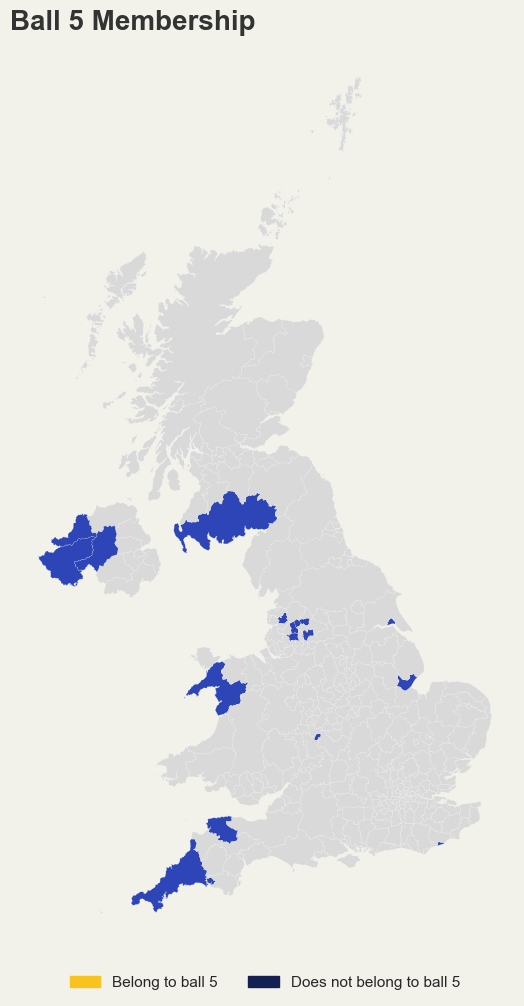

In [2358]:
# ball membership viz

# Define a function to map ball values to colors
def get_color(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Apply the function to the 'ball' column to get the colors
colors = merged['ball_5'].apply(get_color)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set the background color
fig.patch.set_facecolor('#f2f2eb')
ax.set_facecolor('#f2f2eb')

# Plot the data
merged.plot(ax=ax, color=colors, linewidth=0.1)

# Remove all axis lines
ax.axis('off')

# Create a custom legend
legend_labels = [mpatches.Patch(color='#F9C31F', label='Belong to ball 5'),
                 mpatches.Patch(color='#141F52', label='Does not belong to ball 5')]
legend = ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)

# Add a well-formatted headline and subtitle
plt.suptitle('Ball 5 Membership', fontsize=20, fontweight='bold', color='#333333', ha='left', x=0.3, y=0.9)

# Show the plot
plt.show()

In [2359]:
# get LA names in ball
TDA_data[TDA_data['ball'] == 18]['Local_Authority'].unique()

array(['Sevenoaks', 'Surrey Heath'], dtype=object)

In [2360]:
# get LA names in ball

TDA_data[TDA_data['ball'] == 15]['Local_Authority'].unique()

array(['Aberdeenshire', 'Bath and North East Somerset', 'Bedford',
       'Blaby', 'Braintree', 'Colchester', 'Cotswold', 'Derbyshire Dales',
       'Dover', 'Forest of Dean', 'Medway', 'North Somerset',
       'Orkney Islands', 'Stevenage', 'Stockport', 'Watford',
       'West Oxfordshire'], dtype=object)

In [2361]:
# get LA names in ball

TDA_data[TDA_data['ball'] == 4]['Local_Authority'].unique()

array(['Blackburn with Darwen', 'Blackpool', 'Bolsover',
       'Causeway Coast and Glens', 'Derry City and Strabane', 'Gwynedd',
       'Kingston upon Hull, City of', 'Leicester', 'Mansfield',
       'Nottingham', 'Pendle', 'Redditch', 'Sandwell', 'Sunderland',
       'Teignbridge', 'West Devon'], dtype=object)

In [2362]:
# get LA names in ball

TDA_data[TDA_data['ball'] == 14]['Local_Authority'].unique()

array(['Babergh', 'Blaby', 'Conwy', 'Dudley', 'Dundee City',
       'East Staffordshire', "King's Lynn and West Norfolk",
       'Oadby and Wigston', 'Salford', 'Stevenage', 'Torfaen'],
      dtype=object)

In [2363]:
# get LA names in ball

TDA_data[TDA_data['ball'] == 5]['Local_Authority'].unique()

array(['Blackburn with Darwen', 'Bolton', 'Boston', 'Burnley', 'Cornwall',
       'Derry City and Strabane', 'Dumfries and Galloway',
       'Fermanagh and Omagh', 'Gwynedd', 'Hastings', 'Hyndburn',
       'Kingston upon Hull, City of', 'Mid Ulster', 'North Devon',
       'Plymouth', 'Preston', 'Redditch', 'Rochdale'], dtype=object)

In [2364]:
# get LA names in ball

TDA_data[TDA_data['ball'] == 11]['Local_Authority'].unique()

array(['Amber Valley', 'Brighton and Hove', 'Eastleigh', 'Harborough',
       'Hertsmere', 'Maldon', 'Milton Keynes', 'Monmouthshire',
       'South Derbyshire', 'Tewkesbury', 'Wealden'], dtype=object)

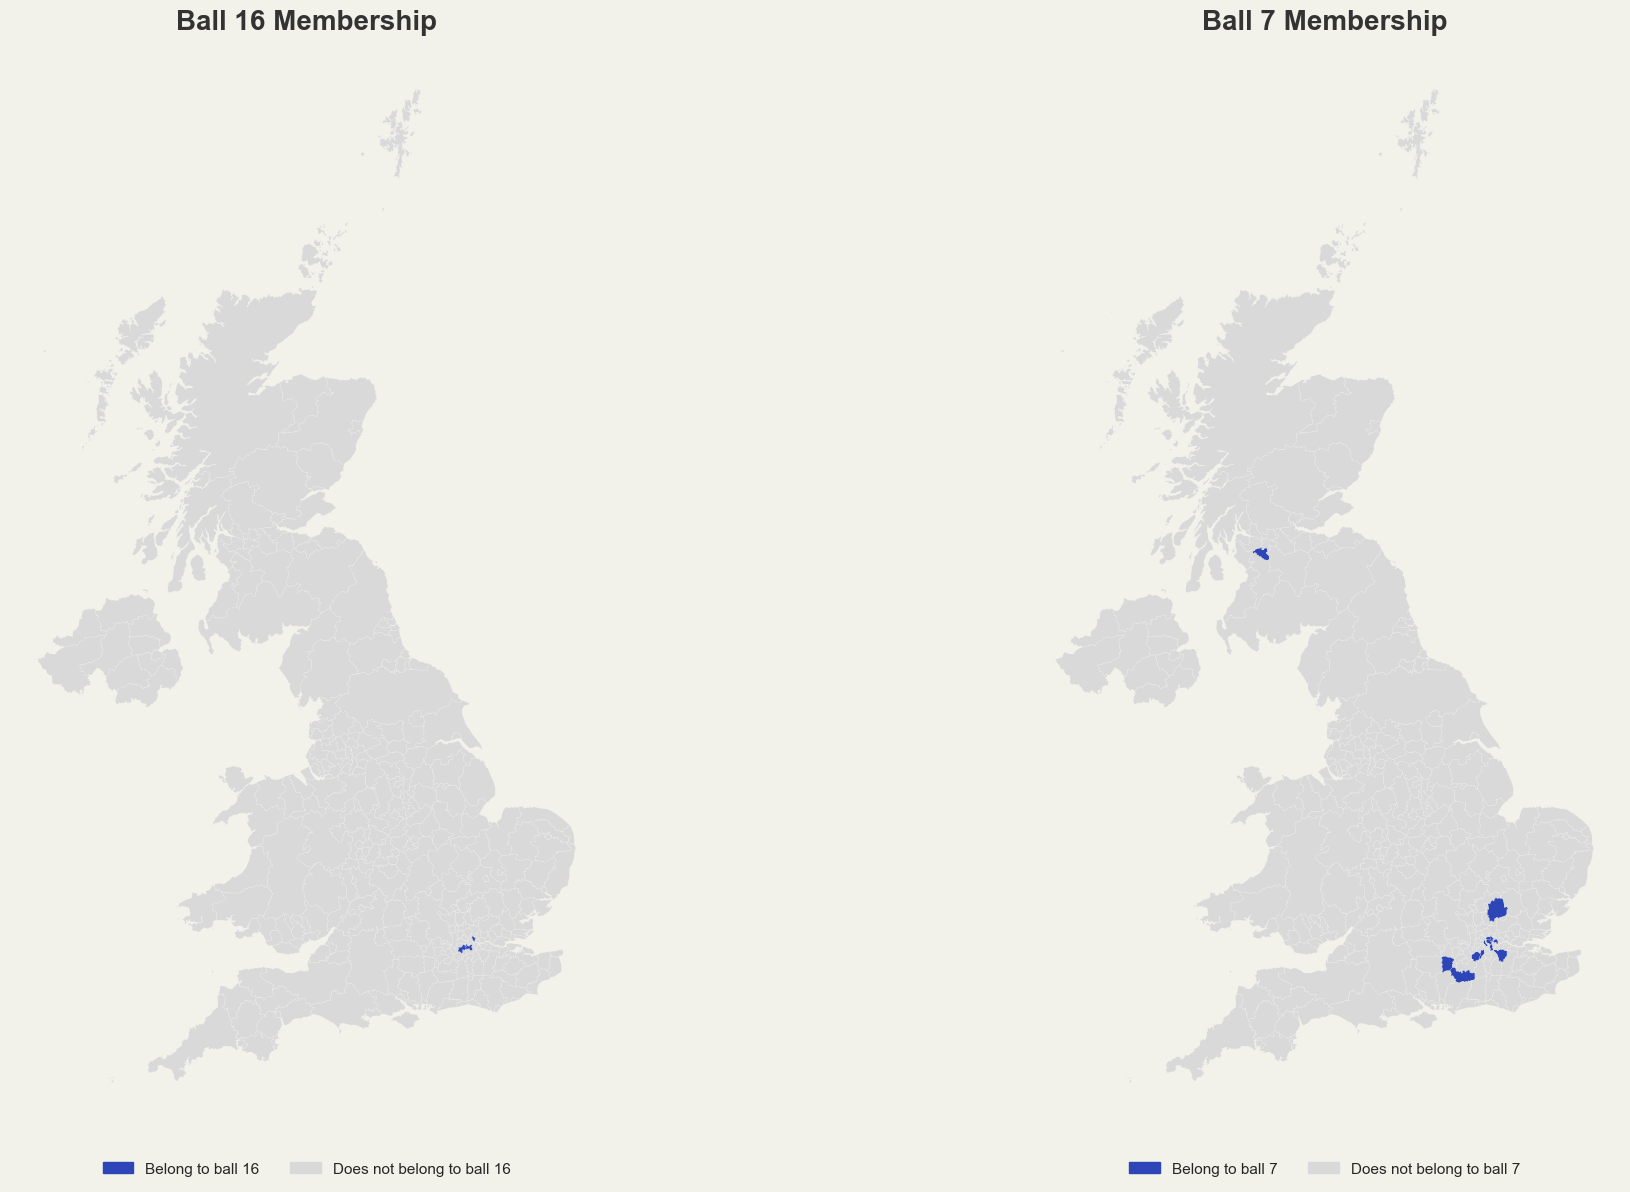

In [2365]:
# Viz ball membership 

# Define a function to map ball values to colors for Ball 16
def get_color_16(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Define a function to map ball values to colors for Ball 7
def get_color_7(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Apply the function to the 'ball_16' column to get the colors for Ball 16
colors_16 = merged['ball_16'].apply(get_color_16)

# Apply the function to the 'ball_7' column to get the colors for Ball 7
colors_7 = merged['ball_7'].apply(get_color_7)

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Set the background color for the figure
fig.patch.set_facecolor('#f2f2eb')

# Plot for Ball 16 Membership
ax1 = axes[0]
ax1.set_facecolor('#f2f2eb')
merged.plot(ax=ax1, color=colors_16, linewidth=0.1)
ax1.axis('off')  # Remove axis lines
legend_labels_16 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 16'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 16')
]
ax1.legend(handles=legend_labels_16, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax1.set_title('Ball 16 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Plot for Ball 7 Membership
ax2 = axes[1]
ax2.set_facecolor('#f2f2eb')
merged.plot(ax=ax2, color=colors_7, linewidth=0.1)
ax2.axis('off')  # Remove axis lines
legend_labels_7 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 7'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 7')
]
ax2.legend(handles=legend_labels_7, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax2.set_title('Ball 7 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Adjust layout to avoid overlap and show the plots
plt.tight_layout()
plt.show()

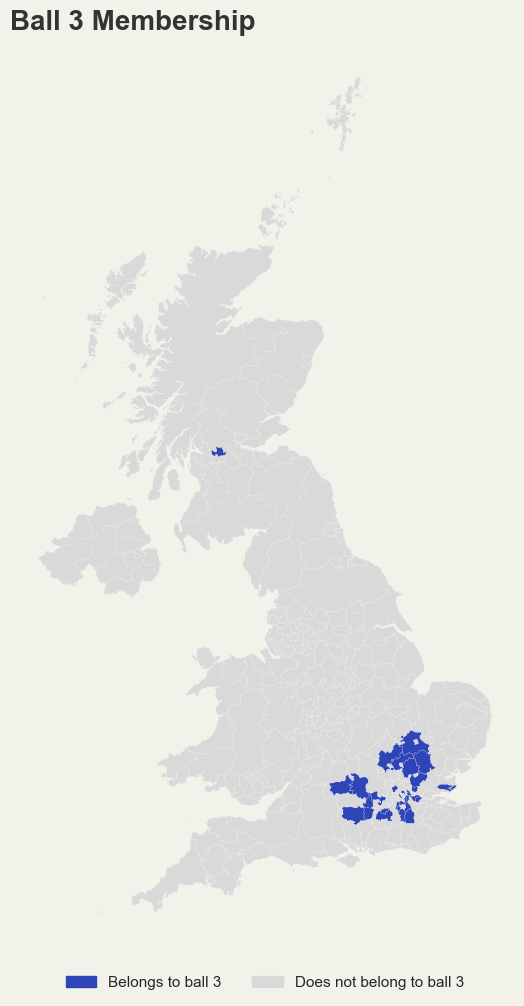

In [2366]:
# viz ball membership

# Apply the function to the 'ball' column to get the colors
colors = merged['ball_3'].apply(get_color)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set the background color
fig.patch.set_facecolor('#f2f2eb')
ax.set_facecolor('#f2f2eb')

# Plot the data
merged.plot(ax=ax, color=colors, linewidth=0.1)

# Remove all axis lines
ax.axis('off')

# Create a custom legend
legend_labels = [
    mpatches.Patch(color='#2E45B8', label='Belongs to ball 3'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 3')]
legend = ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)

# Add a well-formatted headline and subtitle
plt.suptitle('Ball 3 Membership', fontsize=20, fontweight='bold', color='#333333', ha='left', x=0.3, y=0.9)

# Show the plot
plt.show()

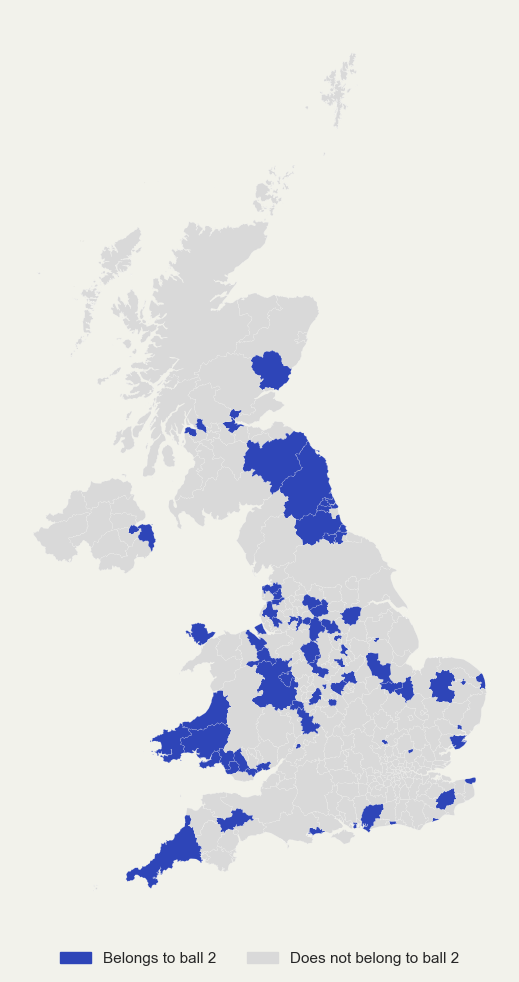

In [2367]:
# ball membershp


# Apply the function to the 'ball' column to get the colors
colors = merged['ball_19'].apply(get_color)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set the background color
fig.patch.set_facecolor('#f2f2eb')
ax.set_facecolor('#f2f2eb')

# Plot the data
merged.plot(ax=ax, color=colors, linewidth=0.1)

# Remove all axis lines
ax.axis('off')

# Create a custom legend
legend_labels = [
    mpatches.Patch(color='#2E45B8', label='Belongs to ball 2'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 2')]
legend = ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)

# Add a well-formatted headline and subtitle
plt.suptitle('', fontsize=20, fontweight='bold', color='#333333', ha='left', x=0.3, y=0.9)

# Show the plot
plt.show()

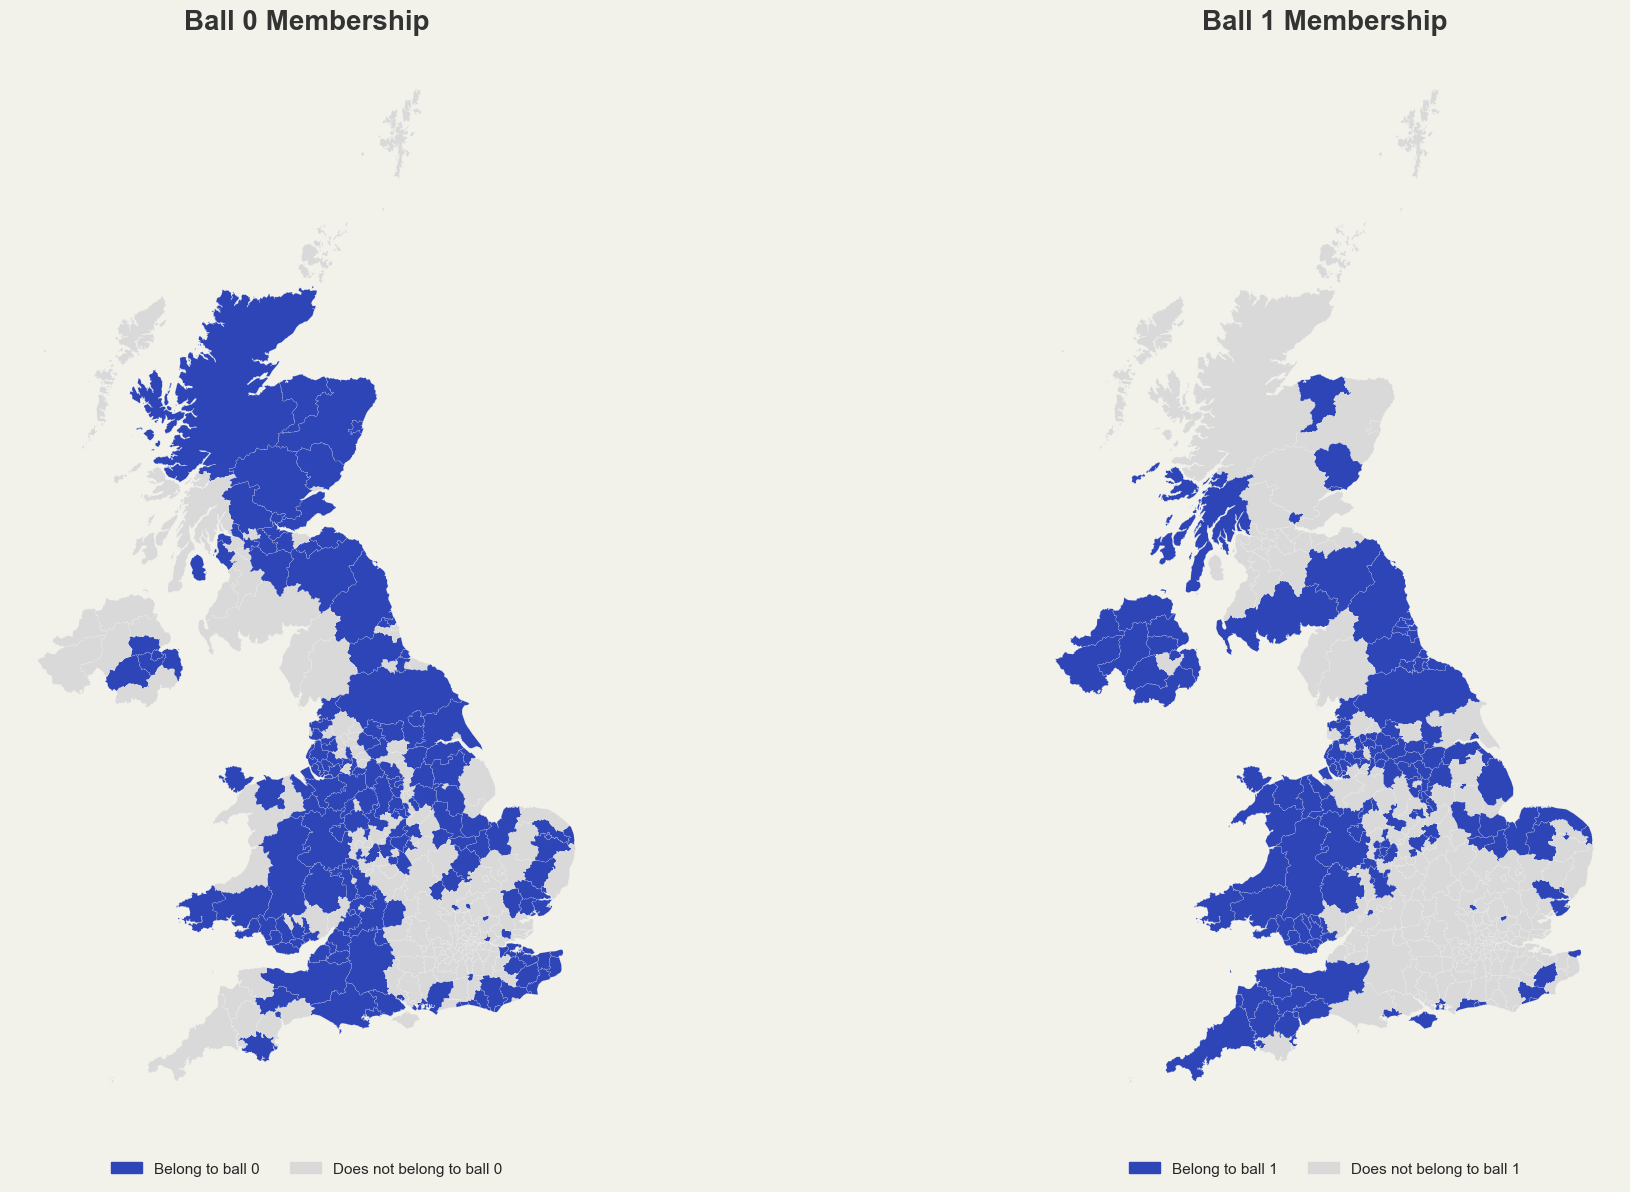

In [2368]:
# ball membership viz 

# Define a function to map ball values to colors for Ball 16
def get_color_16(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Define a function to map ball values to colors for Ball 7
def get_color_7(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Apply the function to the 'ball_16' column to get the colors for Ball 16
colors_16 = merged['ball_0'].apply(get_color_16)

# Apply the function to the 'ball_7' column to get the colors for Ball 7
colors_7 = merged['ball_1'].apply(get_color_7)

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Set the background color for the figure
fig.patch.set_facecolor('#f2f2eb')

# Plot for Ball 16 Membership
ax1 = axes[0]
ax1.set_facecolor('#f2f2eb')
merged.plot(ax=ax1, color=colors_16, linewidth=0.1)
ax1.axis('off')  # Remove axis lines
legend_labels_16 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 0'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 0')
]
ax1.legend(handles=legend_labels_16, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax1.set_title('Ball 0 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Plot for Ball 7 Membership
ax2 = axes[1]
ax2.set_facecolor('#f2f2eb')
merged.plot(ax=ax2, color=colors_7, linewidth=0.1)
ax2.axis('off')  # Remove axis lines
legend_labels_7 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 1'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 1')
]
ax2.legend(handles=legend_labels_7, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax2.set_title('Ball 1 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Adjust layout to avoid overlap and show the plots
plt.tight_layout()
plt.show()

In [2369]:
merged.head()

LAD24CD LAD24NMW   BNG_E   BNG_N     LONG      LAT  \
LAD24NM                                                                      
Hartlepool            E06000001     None  447161  531473 -1.27017  54.6761   
Middlesbrough         E06000002     None  451141  516887 -1.21099  54.5447   
Redcar and Cleveland  E06000003     None  464330  519596 -1.00656  54.5675   
Stockton-on-Tees      E06000004     None  444940  518179 -1.30664  54.5569   
Darlington            E06000005     None  428029  515648 -1.56835  54.5353   

                                                  GlobalID  \
LAD24NM                                                      
Hartlepool            3f58aa35-9ea6-4001-a80f-8aab0e41313f   
Middlesbrough         c5bc1c3e-111f-46db-8e41-362fbbc78d30   
Redcar and Cleveland  29afa1cb-8719-44c2-9906-38bc7bae2981   
Stockton-on-Tees      8ebb86c0-86bb-466e-ae7e-a832eeb755ff   
Darlington            bf2173db-02e1-4b58-9617-e775100f58ec   

                                                               geometry  \
LAD24NM                                                                   
Hartlepool            POLYGON ((448964.105 536757.184, 448986.025 53...   
Middlesbrough         POLYGON ((451894.299 521145.303, 453997.697 51...   
Redcar and Cleveland  POLYGON ((478232.947 518788.803, 477689.303 51...   
Stockton-on-Tees      POLYGON ((452243.536 526335.188, 451711.300 52...   
Darlington            POLYGON ((436388.002 522354.197, 437351.702 52...   

                      resilience_indicator  salaries  ...  ball_12  ball_13  \
LAD24NM                                               ...                     
Hartlepool                             0.0   25257.0  ...      0.0      0.0   
Middlesbrough                          1.0   22819.0  ...      0.0      0.0   
Redcar and Cleveland                   0.0   23552.0  ...      0.0      0.0   
Stockton-on-Tees                       0.0   25498.0  ...      0.0      0.0   
Darlington                             0.0   23764.0  ...      0.0      0.0   

                      ball_14  ball_15  ball_16  ball_17  ball_18  ball_19  \
LAD24NM                                                                      
Hartlepool                0.0      0.0      0.0      0.0      0.0      1.0   
Middlesbrough             0.0      0.0      0.0      0.0      0.0      0.0   
Redcar and Cleveland      0.0      0.0      0.0      0.0      0.0      0.0   
Stockton-on-Tees          0.0      0.0      0.0      0.0      0.0      1.0   
Darlington                0.0      0.0      0.0      0.0      0.0      1.0   

                      ball_20  ball_21  
LAD24NM                                 
Hartlepool                0.0      0.0  
Middlesbrough             0.0      0.0  
Redcar and Cleveland      0.0      0.0  
Stockton-on-Tees          0.0      0.0  
Darlington                0.0      0.0  

[5 rows x 32 columns]

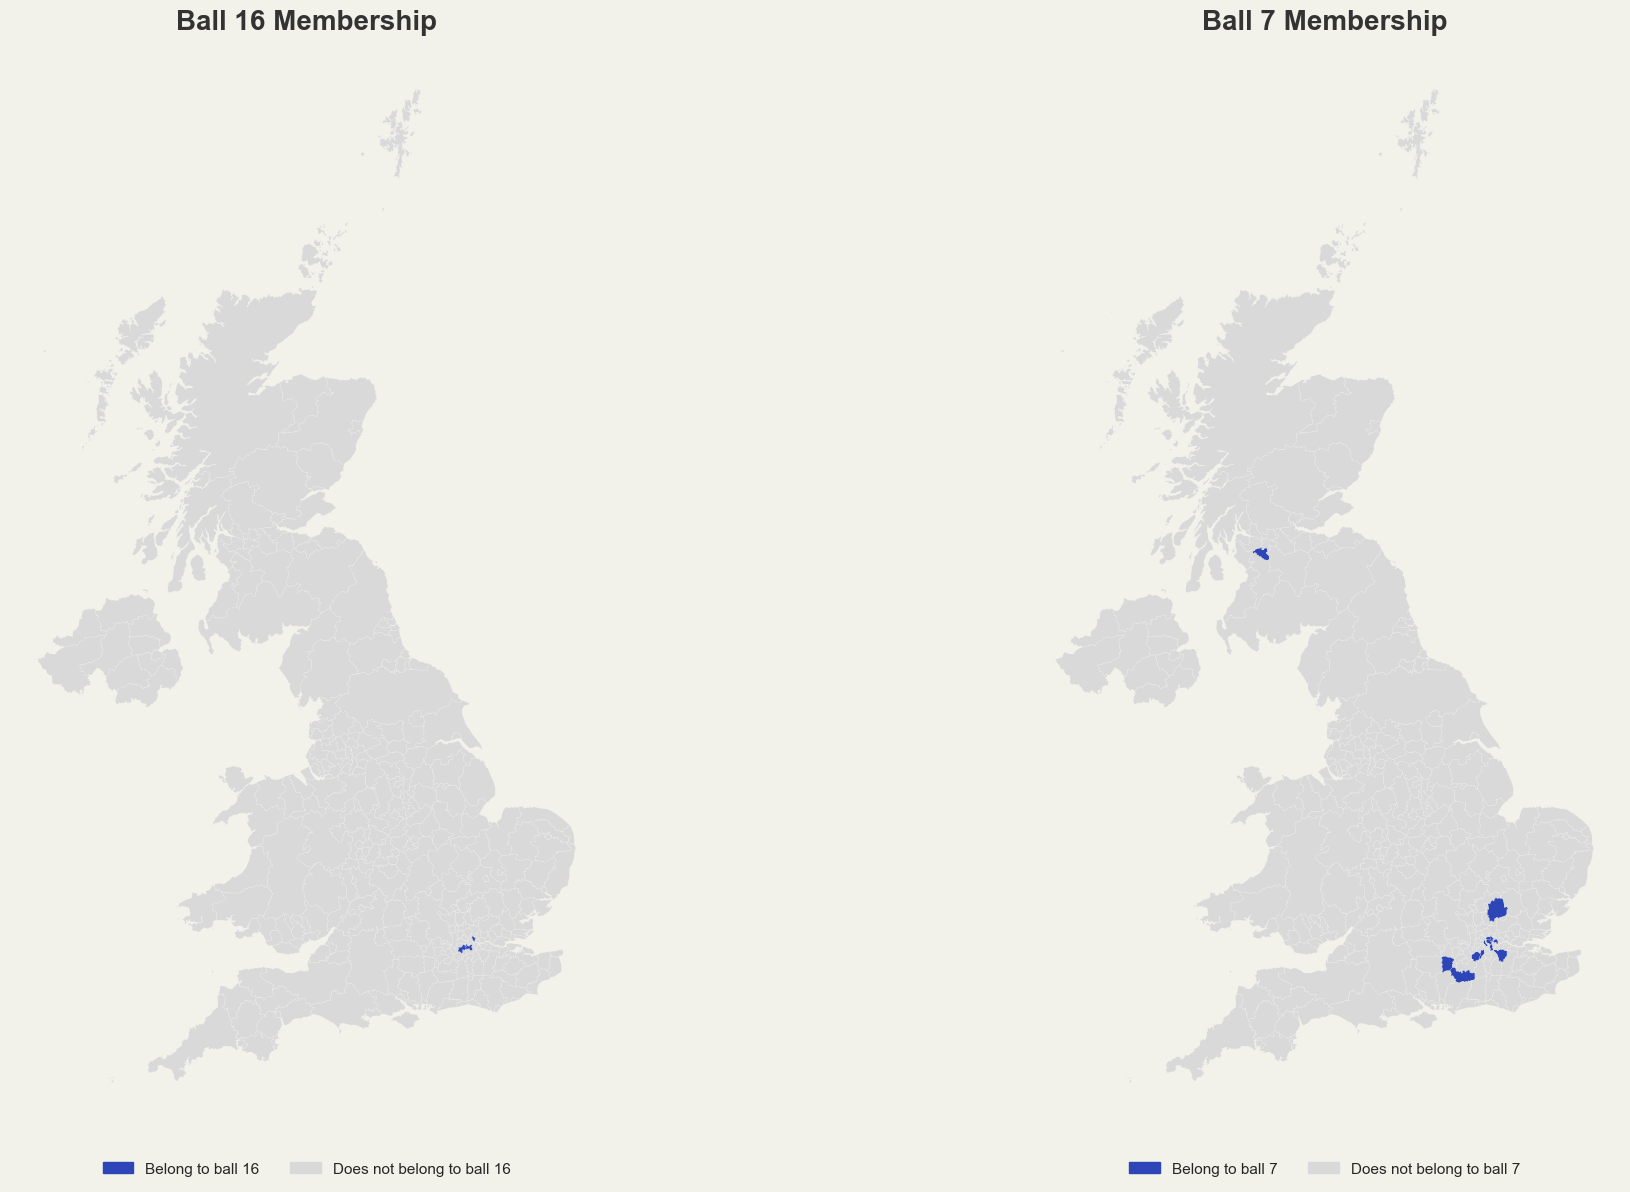

In [2370]:
# ball membership viz 

# Define a function to map ball values to colors for Ball 16
def get_color_16(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Define a function to map ball values to colors for Ball 7
def get_color_7(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Apply the function to the 'ball_16' column to get the colors for Ball 16
colors_16 = merged['ball_16'].apply(get_color_16)

# Apply the function to the 'ball_7' column to get the colors for Ball 7
colors_7 = merged['ball_7'].apply(get_color_7)

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Set the background color for the figure
fig.patch.set_facecolor('#f2f2eb')

# Plot for Ball 16 Membership
ax1 = axes[0]
ax1.set_facecolor('#f2f2eb')
merged.plot(ax=ax1, color=colors_16, linewidth=0.1)
ax1.axis('off')  # Remove axis lines
legend_labels_16 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 16'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 16')
]
ax1.legend(handles=legend_labels_16, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax1.set_title('Ball 16 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Plot for Ball 7 Membership
ax2 = axes[1]
ax2.set_facecolor('#f2f2eb')
merged.plot(ax=ax2, color=colors_7, linewidth=0.1)
ax2.axis('off')  # Remove axis lines
legend_labels_7 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 7'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 7')
]
ax2.legend(handles=legend_labels_7, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax2.set_title('Ball 7 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Adjust layout to avoid overlap and show the plots
plt.tight_layout()
plt.show()

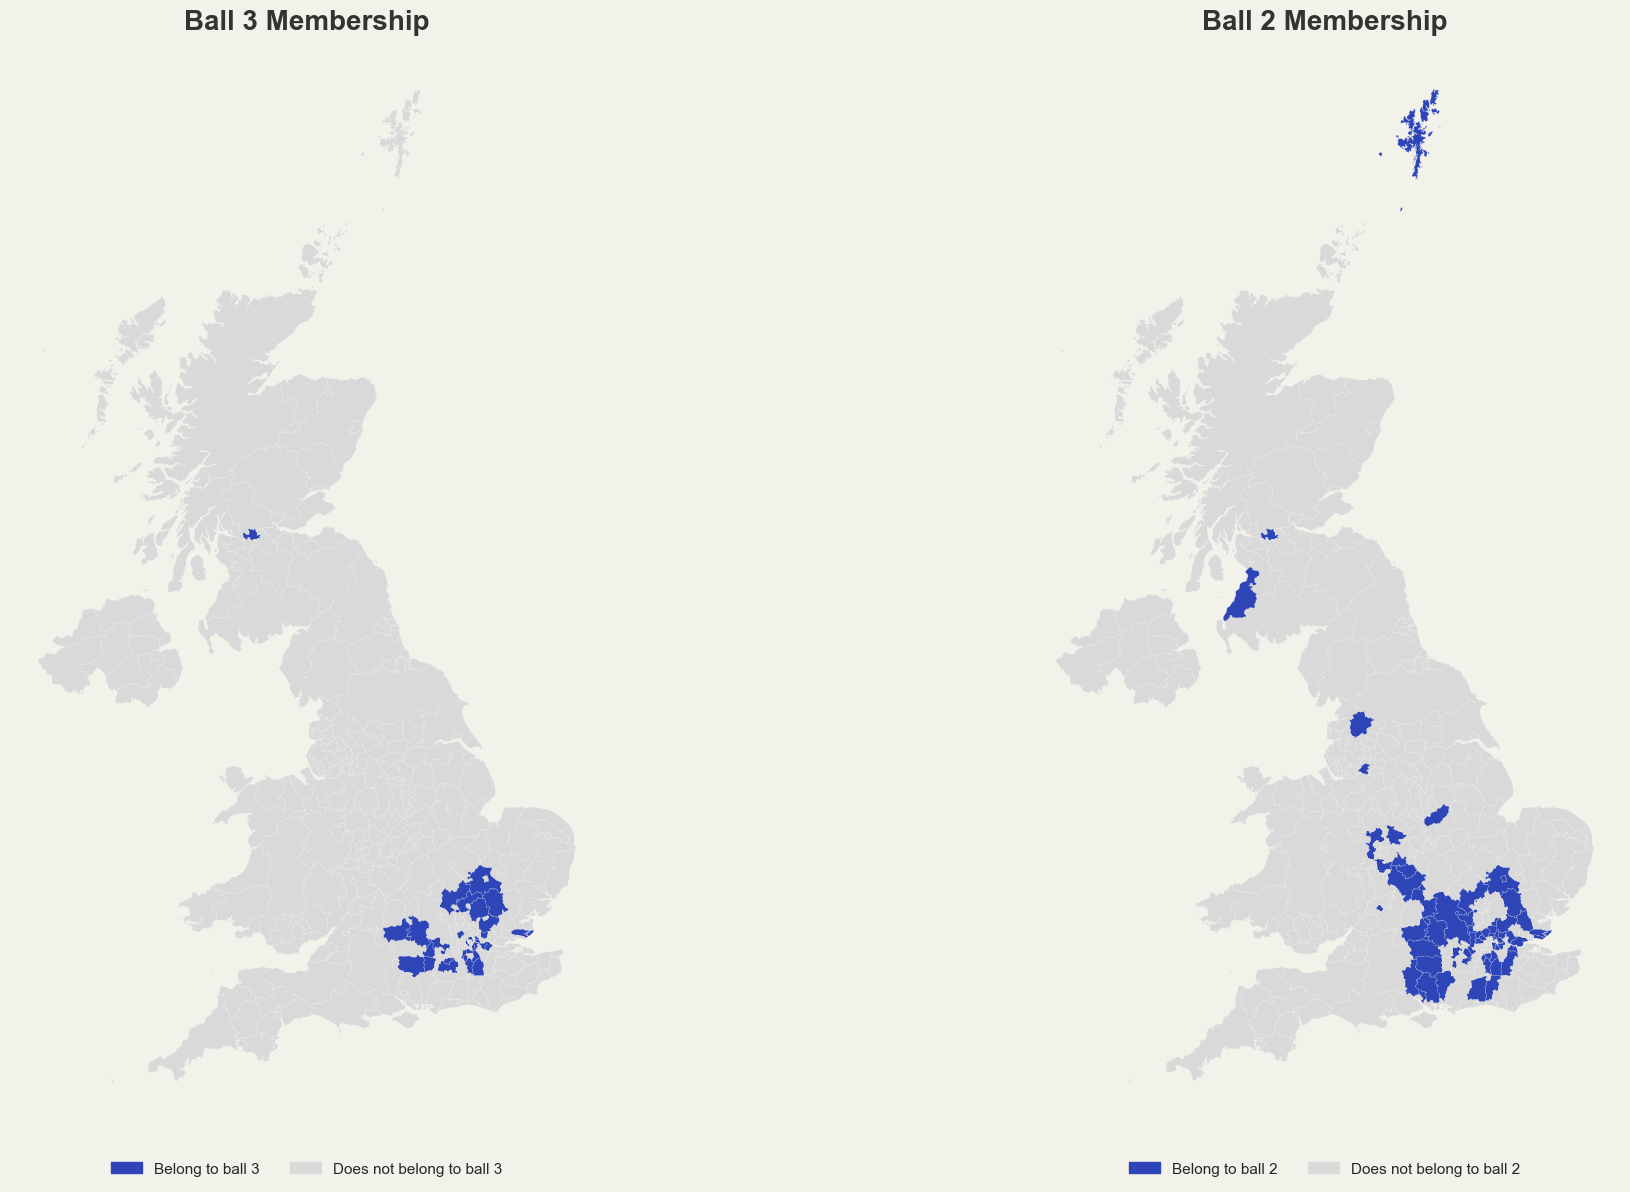

In [2371]:
# more ball membershpi vzis

# Define a function to map ball values to colors for Ball 16
def get_color_16(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Define a function to map ball values to colors for Ball 7
def get_color_7(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Apply the function to the 'ball_16' column to get the colors for Ball 16
colors_16 = merged['ball_3'].apply(get_color_16)

# Apply the function to the 'ball_7' column to get the colors for Ball 7
colors_7 = merged['ball_2'].apply(get_color_7)

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Set the background color for the figure
fig.patch.set_facecolor('#f2f2eb')

# Plot for Ball 16 Membership
ax1 = axes[0]
ax1.set_facecolor('#f2f2eb')
merged.plot(ax=ax1, color=colors_16, linewidth=0.1)
ax1.axis('off')  # Remove axis lines
legend_labels_16 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 3'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 3')
]
ax1.legend(handles=legend_labels_16, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax1.set_title('Ball 3 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Plot for Ball 7 Membership
ax2 = axes[1]
ax2.set_facecolor('#f2f2eb')
merged.plot(ax=ax2, color=colors_7, linewidth=0.1)
ax2.axis('off')  # Remove axis lines
legend_labels_7 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 2'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 2')
]
ax2.legend(handles=legend_labels_7, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax2.set_title('Ball 2 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Adjust layout to avoid overlap and show the plots
plt.tight_layout()
plt.show()

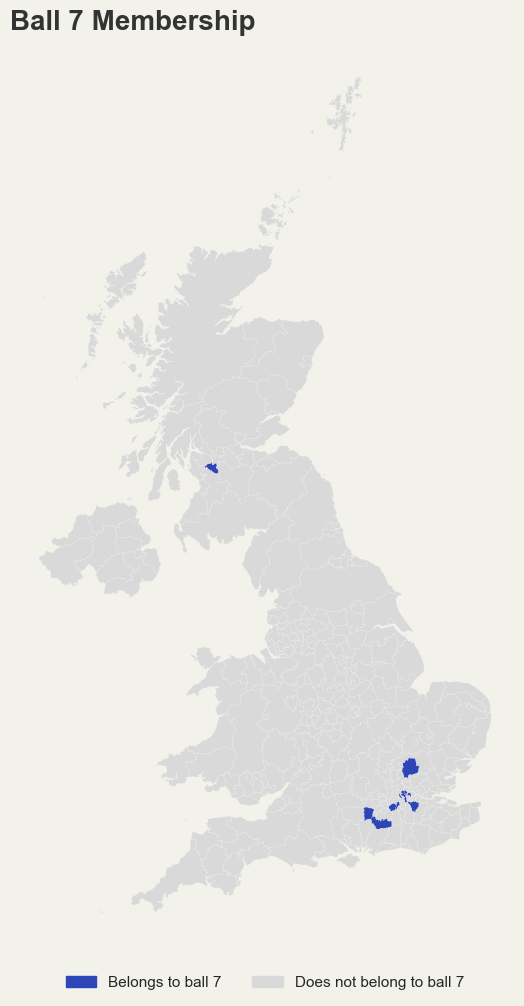

In [2372]:
# ball viz

# Apply the function to the 'ball' column to get the colors
colors = merged['ball_7'].apply(get_color)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set the background color
fig.patch.set_facecolor('#f2f2eb')
ax.set_facecolor('#f2f2eb')

# Plot the data
merged.plot(ax=ax, color=colors, linewidth=0.1)

# Remove all axis lines
ax.axis('off')

# Create a custom legend
legend_labels = [
    mpatches.Patch(color='#2E45B8', label='Belongs to ball 7'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 7')]
legend = ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)

# Add a well-formatted headline and subtitle
plt.suptitle('Ball 7 Membership', fontsize=20, fontweight='bold', color='#333333', ha='left', x=0.3, y=0.9)

# Show the plot
plt.show()

In [2373]:
TDA_data.head()

Local_Authority  resilience_indicator  point  ball  Year  salaries
3855   Aberdeen City                     0      0     0  2020   28113.0
3856   Aberdeenshire                     0      1     0  2020   31194.0
3857   Aberdeenshire                     0      1     8  2020   31194.0
3858   Aberdeenshire                     0      1     9  2020   31194.0
3859   Aberdeenshire                     0      1    15  2020   31194.0

In [2374]:
merged.reset_index(drop=False, inplace=True)

In [2375]:
# check urban classification data
urban_rural.head()

Local authority code Local authority name Summary_Classification
0            S12000033        Aberdeen City             Other City
1            S12000034        Aberdeenshire     Village or smaller
2            E07000223                 Adur            Medium Town
3            E07000026            Allerdale     Village or smaller
4            E07000032         Amber Valley             Small Town

In [2376]:
# check the classification
urban_rural['Summary_Classification'].unique()

array(['Other City', 'Village or smaller', 'Medium Town', 'Small Town',
       'Large Town', 'Core City'], dtype=object)

In [2377]:
# make a copy of a dataset for transformation into urban rural 
bi_urban_rural = urban_rural.copy()

def classify_urban_rural(classification):
    if classification in ['Core City', 'Large Town', 'Medium Town']:
        return 'Urban'
    else:
        return 'Rural'

# Apply the function to create a new column 'Urban_Rural_Classification'
bi_urban_rural['Urban_Rural_Classification'] = bi_urban_rural['Summary_Classification'].apply(classify_urban_rural)


In [2378]:
# drop old classification
bi_urban_rural.drop('Summary_Classification', axis=1, inplace=True)

In [2379]:
# inscpect
bi_urban_rural.head()

Local authority code Local authority name Urban_Rural_Classification
0            S12000033        Aberdeen City                      Rural
1            S12000034        Aberdeenshire                      Rural
2            E07000223                 Adur                      Urban
3            E07000026            Allerdale                      Rural
4            E07000032         Amber Valley                      Rural

In [2380]:
# get dummies for colouring 
urban_rural = pd.get_dummies(urban_rural, columns=['Summary_Classification'], prefix='SC', dtype=int)


In [2381]:
# rename LA for merging
urban_rural.rename(columns={'Local authority name': 'Local_Authority'}, inplace=True)


In [2382]:
# make binary dummy vars for urban rural
bi_urban_rural = pd.get_dummies(bi_urban_rural, columns=['Urban_Rural_Classification'], prefix='SC', dtype=int)
bi_urban_rural.rename(columns={'Local authority name': 'Local_Authority'}, inplace=True)


In [2383]:
# pivot the data and merge them
some_data = data.pivot(index='Local_Authority', columns='Year', values='adjusted_salary')
some_data.columns = [f'salaries_{col}' for col in some_data.columns]
some_data.reset_index(inplace=True)
urban_data = some_data.merge(urban_rural, on='Local_Authority')
urban_data_binary = some_data.merge(bi_urban_rural, on='Local_Authority')

In [2384]:
# inspect
urban_data.head()

Local_Authority  salaries_2015  salaries_2016  salaries_2017  salaries_2018  \
0   Aberdeen City        30151.0        29059.0        27510.0        28141.0   
1   Aberdeenshire        30535.0        29591.0        28411.0        29129.0   
2            Adur        25227.0        24401.0        23675.0        25256.0   
3    Amber Valley        26694.0        27556.0        28987.0        28015.0   
4           Angus        26471.0        27233.0        26572.0        27408.0   

   salaries_2019  salaries_2020  salaries_2021  salaries_2022  salaries_2023  \
0        28224.0        28113.0        26848.0        26689.0        27335.0   
1        30185.0        31194.0        28747.0        28895.0        28230.0   
2        25899.0        27778.0        25787.0        26851.0        25659.0   
3        27460.0        30867.0        28126.0        25343.0        25477.0   
4        27211.0        27418.0        26939.0        26076.0        26653.0   

  Local authority code  SC_Core City  SC_Large Town  SC_Medium Town  \
0            S12000033             0              0               0   
1            S12000034             0              0               0   
2            E07000223             0              0               1   
3            E07000032             0              0               0   
4            S12000041             0              0               0   

   SC_Other City  SC_Small Town  SC_Village or smaller  
0              1              0                      0  
1              0              0                      1  
2              0              0                      0  
3              0              1                      0  
4              0              1                      0

In [2385]:
#  inspect
urban_data_binary.head()

Local_Authority  salaries_2015  salaries_2016  salaries_2017  salaries_2018  \
0   Aberdeen City        30151.0        29059.0        27510.0        28141.0   
1   Aberdeenshire        30535.0        29591.0        28411.0        29129.0   
2            Adur        25227.0        24401.0        23675.0        25256.0   
3    Amber Valley        26694.0        27556.0        28987.0        28015.0   
4           Angus        26471.0        27233.0        26572.0        27408.0   

   salaries_2019  salaries_2020  salaries_2021  salaries_2022  salaries_2023  \
0        28224.0        28113.0        26848.0        26689.0        27335.0   
1        30185.0        31194.0        28747.0        28895.0        28230.0   
2        25899.0        27778.0        25787.0        26851.0        25659.0   
3        27460.0        30867.0        28126.0        25343.0        25477.0   
4        27211.0        27418.0        26939.0        26076.0        26653.0   

  Local authority code  SC_Rural  SC_Urban  
0            S12000033         1         0  
1            S12000034         1         0  
2            E07000223         0         1  
3            E07000032         1         0  
4            S12000041         1         0

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



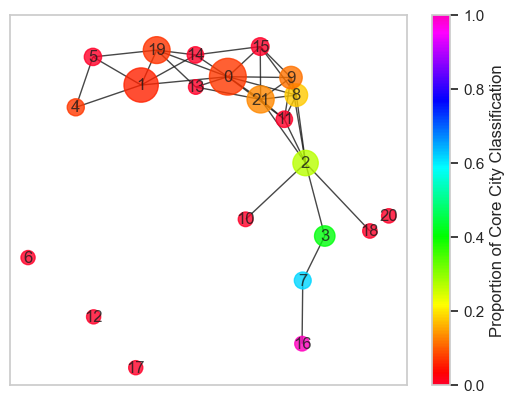

In [2386]:
# TDA plot by core urban classification
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Core City'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Core City', color_palette=hsvp, colorbar=True, colorbar_label="Proportion of Core City Classification",
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))
plt.grid(False)  # This removes gridlines


/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



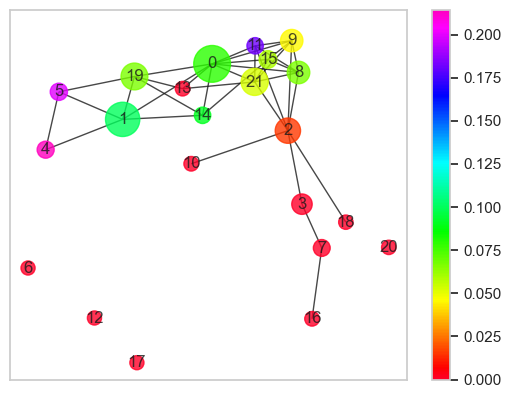

In [2387]:
# TDA plot by large town classification
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Other City'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Other City', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))
plt.grid(False) 

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

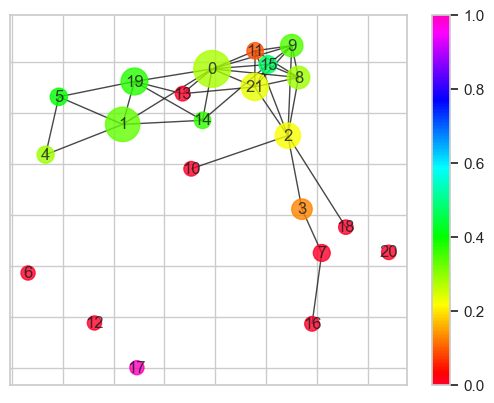

In [2388]:
# TDA plot by large town classification
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Large Town'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Large Town', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

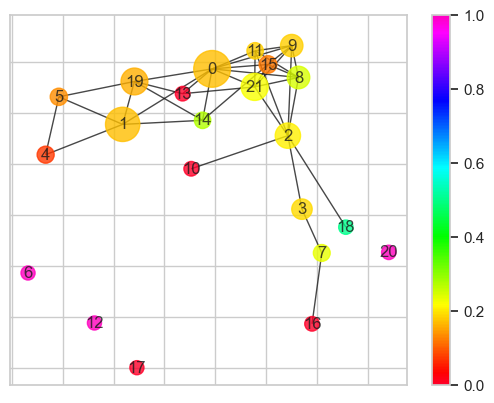

In [2389]:
# TDA plot by medium town classification
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Medium Town'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Medium Town', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

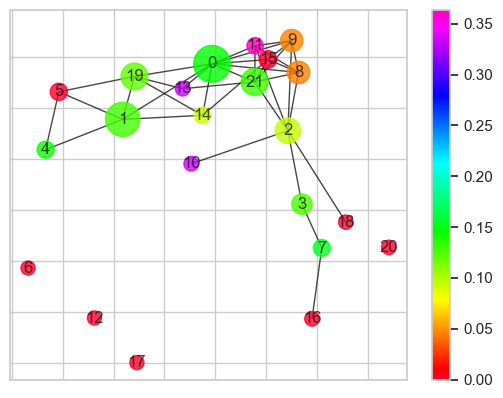

In [2390]:
# TDA plot by small town classification
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Small Town'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Small Town', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

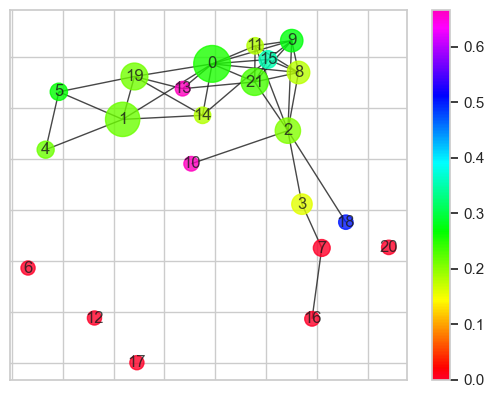

In [2391]:
# TDA plot by village classification
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Village or smaller'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Village or smaller', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



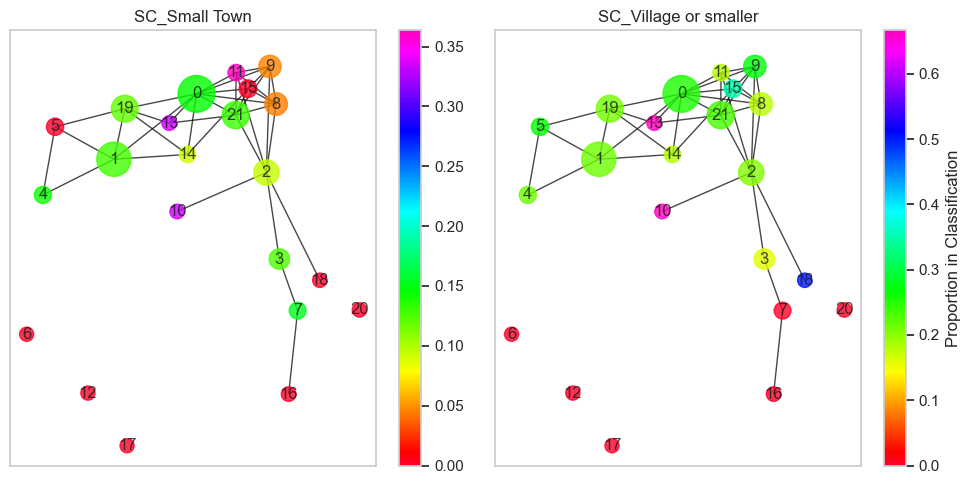

In [2392]:

# TDA plot for a viz in the report 

# Create a figure with 1 row and 2 columns for the two plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize for appropriate sizing

# Plot 1: SC_Small Town
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf_small_town = pd.DataFrame(urban_data['SC_Small Town'])
bm_small_town = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_small_town)
hsvp = cm.get_cmap("gist_rainbow")

# Draw network for 'SC_Small Town'
bm_small_town.draw_networkx(coloring_variable='SC_Small Town', color_palette=hsvp, colorbar=True, 
                            pos=nx.spring_layout(bm_small_town.Graph, k=0.7, seed=55), ax=axes[0])
axes[0].set_title('SC_Small Town')
axes[0].grid(False)

# Plot 2: SC_Village or smaller
cdf_village = pd.DataFrame(urban_data['SC_Village or smaller'])
bm_village = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_village)

# Draw network for 'SC_Village or smaller'
bm_village.draw_networkx(coloring_variable='SC_Village or smaller', color_palette=hsvp, colorbar=True, colorbar_label="Proportion in Classification",
                         pos=nx.spring_layout(bm_village.Graph, k=0.7, seed=55), ax=axes[1])
axes[1].set_title('SC_Village or smaller')
axes[1].grid(False)

# Display the combined figure
plt.tight_layout()
plt.show()

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



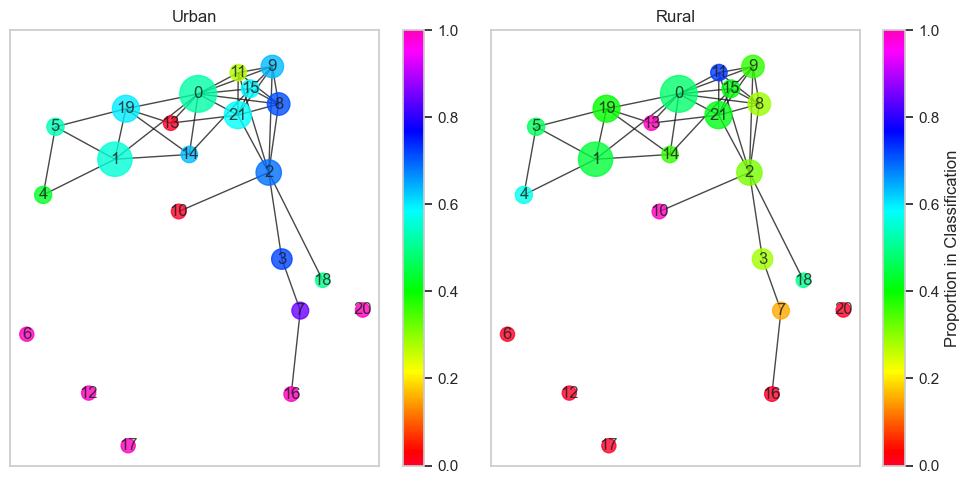

In [2393]:
# Binary urba to rural plot 

# Create a figure with 1 row and 2 columns for the two plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize for appropriate sizing

# Plot 1: SC_Small Town
bmx1 = urban_data_binary[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf_small_town = pd.DataFrame(urban_data_binary['SC_Urban'])
bm_small_town = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_small_town)
hsvp = cm.get_cmap("gist_rainbow")

# Draw network for 'SC_Small Town'
bm_small_town.draw_networkx(coloring_variable='SC_Urban', color_palette=hsvp, colorbar=True, 
                            pos=nx.spring_layout(bm_small_town.Graph, k=0.7, seed=55), ax=axes[0])
axes[0].set_title('Urban')
axes[0].grid(False)

# Plot 2: SC_Village or smaller
cdf_village = pd.DataFrame(urban_data_binary['SC_Rural'])
bm_village = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_village)

# Draw network for 'SC_Village or smaller'
bm_village.draw_networkx(coloring_variable='SC_Rural', color_palette=hsvp, colorbar=True, colorbar_label="Proportion in Classification",
                         pos=nx.spring_layout(bm_village.Graph, k=0.7, seed=55), ax=axes[1])
axes[1].set_title('Rural')
axes[1].grid(False)

# Display the combined figure
plt.tight_layout()
plt.show()

In [2394]:
print(merged[merged['ball_10'] == 1]['LAD24NM'])

64     East Cambridgeshire
197              Runnymede
321       Shetland Islands
Name: LAD24NM, dtype: object


In [2395]:
print(merged[merged['ball_13'] == 1]['LAD24NM'])

187    Staffordshire Moorlands
216              Malvern Hills
312         Na h-Eileanan Siar
Name: LAD24NM, dtype: object


In [2396]:
print(merged[merged['ball_11'] == 1]['LAD24NM'])

39         Milton Keynes
40     Brighton and Hove
68          Amber Valley
75      South Derbyshire
88               Wealden
97                Maldon
106           Tewkesbury
109            Eastleigh
120            Hertsmere
150           Harborough
357        Monmouthshire
Name: LAD24NM, dtype: object


In [2397]:
TDA_data.head()

Local_Authority  resilience_indicator  point  ball  Year  salaries
3855   Aberdeen City                     0      0     0  2020   28113.0
3856   Aberdeenshire                     0      1     0  2020   31194.0
3857   Aberdeenshire                     0      1     8  2020   31194.0
3858   Aberdeenshire                     0      1     9  2020   31194.0
3859   Aberdeenshire                     0      1    15  2020   31194.0

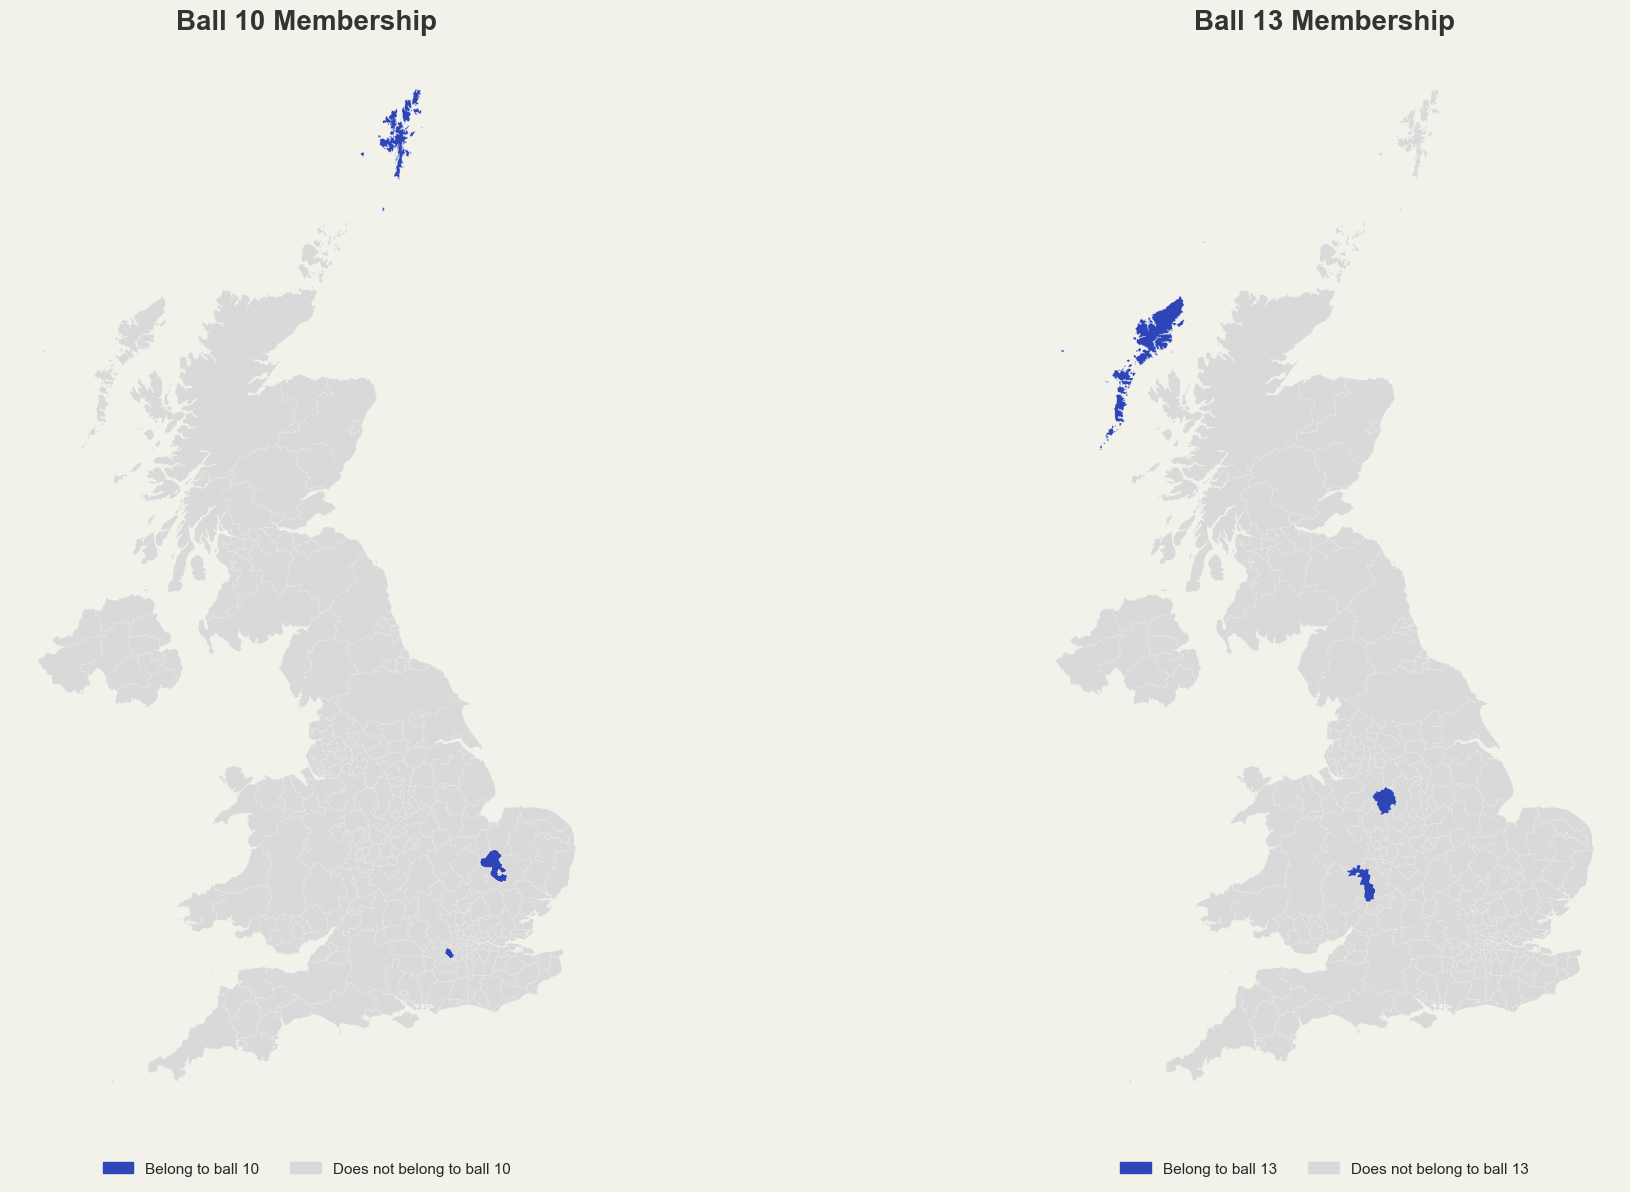

In [2398]:
# Additional plot to took at ball memberships

# Define a function to map ball values to colors for Ball 16
def get_color_16(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Define a function to map ball values to colors for Ball 7
def get_color_7(value):
    return '#2E45B8' if value == 1 else '#D9D9D9'

# Apply the function to the 'ball_16' column to get the colors for Ball 16
colors_16 = merged['ball_10'].apply(get_color_16)

# Apply the function to the 'ball_7' column to get the colors for Ball 7
colors_7 = merged['ball_13'].apply(get_color_7)

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Set the background color for the figure
fig.patch.set_facecolor('#f2f2eb')

# Plot for Ball 16 Membership
ax1 = axes[0]
ax1.set_facecolor('#f2f2eb')
merged.plot(ax=ax1, color=colors_16, linewidth=0.1)
ax1.axis('off')  # Remove axis lines
legend_labels_16 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 10'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 10')
]
ax1.legend(handles=legend_labels_16, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax1.set_title('Ball 10 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Plot for Ball 7 Membership
ax2 = axes[1]
ax2.set_facecolor('#f2f2eb')
merged.plot(ax=ax2, color=colors_7, linewidth=0.1)
ax2.axis('off')  # Remove axis lines
legend_labels_7 = [
    mpatches.Patch(color='#2E45B8', label='Belong to ball 13'),
    mpatches.Patch(color='#D9D9D9', label='Does not belong to ball 13')
]
ax2.legend(handles=legend_labels_7, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)
ax2.set_title('Ball 13 Membership', fontsize=20, fontweight='bold', color='#333333', ha='center')

# Adjust layout to avoid overlap and show the plots
plt.tight_layout()
plt.show()

In [2399]:
# inspect balls
print(merged[merged['ball_13'] == 1]['LAD24NM'])

187    Staffordshire Moorlands
216              Malvern Hills
312         Na h-Eileanan Siar
Name: LAD24NM, dtype: object


In [2400]:
# inspect balls

print(merged[merged['ball_18'] == 1]['LAD24NM'])

130       Sevenoaks
199    Surrey Heath
Name: LAD24NM, dtype: object


# Clustering comparison

In [2401]:
#make clustering data
clustering_data = TDA_data[['Local_Authority', 'Year', 'salaries']]

In [2402]:
#drop duplicates 
clustering_data.drop_duplicates(subset='Local_Authority', inplace=True)

/var/folders/kh/kvrs5sp15tx0d3k647zd9b540000gn/T/ipykernel_33340/3080086968.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [2403]:
# Pivot the data to have one row per local authority and one column per year
wide_data = clustering_data.pivot(index='Local_Authority', columns='Year', values='salaries')

In [2404]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(wide_data)

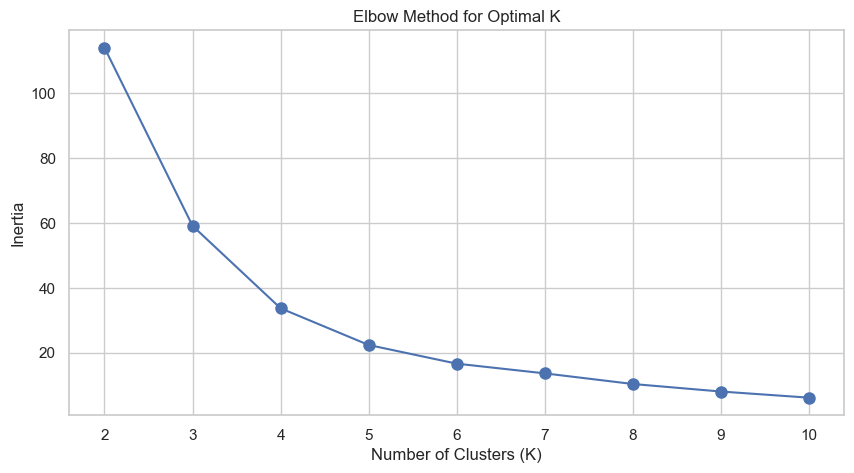

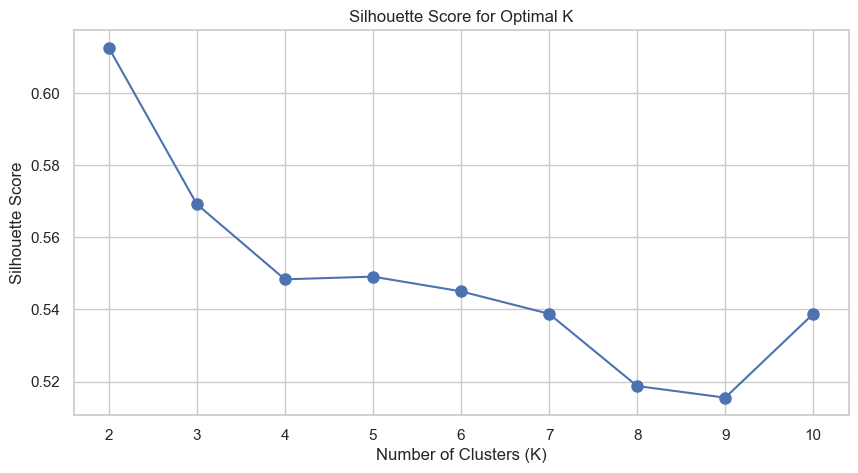

In [2405]:
# Elbow method to find the optimal number of clusters
inertia = []
silhouette_scores = []

K_range = range(2, 11)  # Test for K from 2 to 10

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(scaled_data)
    
    inertia.append(kmeans.inertia_)
    
    # Compute silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow method
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

In [2406]:
# run k-means

K_optimal = 4  

# Initialize and fit K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=K_optimal, random_state=42)
kmeans.fit(scaled_data)

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the original data
wide_data['Cluster'] = labels


In [2407]:
# see the centroids and the cluster counts
centroids = kmeans.cluster_centers_

# Convert centroids back to original scale
centroids_original = scaler.inverse_transform(centroids)

# Create a DataFrame for centroids
centroid_df = pd.DataFrame(centroids_original, columns=wide_data.columns[:-1])

print("Cluster Centroids (Original Scale):")
print(centroid_df)

# Display the number of local authorities in each cluster
print("Number of local authorities in each cluster:")
print(wide_data['Cluster'].value_counts())

Cluster Centroids (Original Scale):
Year          2020
0     24828.156863
1     38505.793103
2     32329.645833
3     27989.208000
Number of local authorities in each cluster:
Cluster
3    125
0    102
2     96
1     29
Name: count, dtype: int64


In [2408]:
# get wide data
wide_data = wide_data.reset_index()

wide_data_for_merge = wide_data[['Local_Authority', 'Cluster']]

In [2409]:
wide_data_for_merge.head()

Year Local_Authority  Cluster
0      Aberdeen City        3
1      Aberdeenshire        2
2               Adur        3
3       Amber Valley        2
4              Angus        3

In [2410]:
# get a copy of TDA data for analysis
TDA_cluster_data = TDA_data

In [2411]:
# Merge TDA_data with cluster_column_data on Local_Authority
TDA_cluster_data = pd.merge(TDA_data, wide_data_for_merge, on='Local_Authority', how='left')

# check data
TDA_cluster_data.head()

Local_Authority  resilience_indicator  point  ball  Year  salaries  Cluster
0   Aberdeen City                     0      0     0  2020   28113.0        3
1   Aberdeenshire                     0      1     0  2020   31194.0        2
2   Aberdeenshire                     0      1     8  2020   31194.0        2
3   Aberdeenshire                     0      1     9  2020   31194.0        2
4   Aberdeenshire                     0      1    15  2020   31194.0        2

In [2412]:
cluster_geo = shapefile.set_index('LAD24NM').join(TDA_cluster_data.set_index('Local_Authority'))

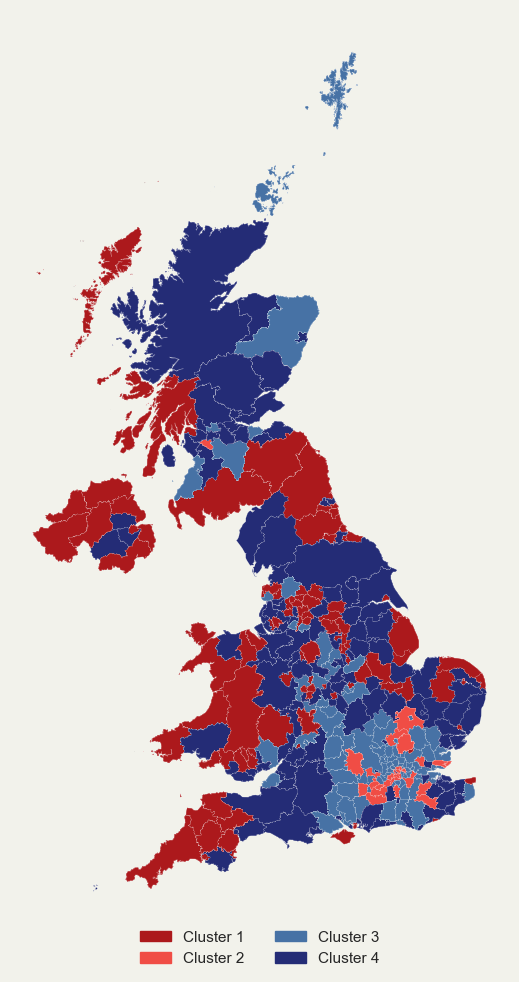

In [2413]:
# Make a cluster map 

# Define new color list and colormap for 4 categories
colors_list = ['#ac191c', '#f04d45', '#4772a5', '#242c76']
cmap = LinearSegmentedColormap.from_list('RedBlue', colors_list, N=4)

# Adjust normalization for 4 categories (0 to 3)
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

# Apply the colormap to the 'Cluster' column to get the colors
colors = cmap(norm(cluster_geo['Cluster']))

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set the background color
fig.patch.set_facecolor('#f2f2eb')
ax.set_facecolor('#f2f2eb')

# Plot the data
cluster_geo.plot(ax=ax, color=colors, linewidth=0.1)

# Remove all axis lines
ax.axis('off')

# Create a custom legend to reflect 4 categories
legend_labels = [
    mpatches.Patch(color=cmap(0), label='Cluster 1'),
    mpatches.Patch(color=cmap(1), label='Cluster 2'),
    mpatches.Patch(color=cmap(2), label='Cluster 3'),
    mpatches.Patch(color=cmap(3), label='Cluster 4')
]

# Add the legend
legend = ax.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=2)

# Add a well-formatted headline and subtitle
plt.suptitle('', 
             fontsize=20, fontweight='bold', color='#333333', ha='left', x=0.3, y=0.9)

# Show the plot
plt.show()

In [2414]:
# get cluster data
New_TDA_Cluster = TDA_cluster_data[['Local_Authority', 'Year', 'salaries', 'Cluster']]

In [2415]:
New_TDA_Cluster.head()

Local_Authority  Year  salaries  Cluster
0   Aberdeen City  2020   28113.0        3
1   Aberdeenshire  2020   31194.0        2
2   Aberdeenshire  2020   31194.0        2
3   Aberdeenshire  2020   31194.0        2
4   Aberdeenshire  2020   31194.0        2

In [2416]:
# drop duplicates
New_TDA_Cluster = New_TDA_Cluster.drop_duplicates()

In [2417]:
# Pivot the data to have one row per local authority and one column per year
df_pivot = New_TDA_Cluster.pivot(index=['Local_Authority', 'Cluster'], columns='Year', values='salaries')

# Flatten the columns (if you want to remove the multi-level column index)
df_pivot.columns = [f'salaries_{col}' for col in df_pivot.columns]

# Reset index to make 'Local_Authority' and 'Cluster' regular columns
df_pivot = df_pivot.reset_index()

In [2418]:
# One-hot encoding for cluser column to make  a tda plott
df_dummies = pd.get_dummies(df_pivot['Cluster'], prefix='Cluster', dtype=int)

# Concatenate the dummy variables with the original DataFrame (excluding the original 'Cluster' column)
df_wider = pd.concat([df_pivot.drop('Cluster', axis=1), df_dummies], axis=1)



In [2419]:
# inspect
df_wider.head()

Local_Authority  salaries_2020  salaries_2021  salaries_2022  salaries_2023  \
0   Aberdeen City        28113.0        26848.0        26689.0        27335.0   
1   Aberdeenshire        31194.0        28747.0        28895.0        28230.0   
2            Adur        27778.0        25787.0        26851.0        25659.0   
3    Amber Valley        30867.0        28126.0        25343.0        25477.0   
4           Angus        27418.0        26939.0        26076.0        26653.0   

   Cluster_0  Cluster_1  Cluster_2  Cluster_3  
0          0          0          0          1  
1          0          0          1          0  
2          0          0          0          1  
3          0          0          1          0  
4          0          0          0          1

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



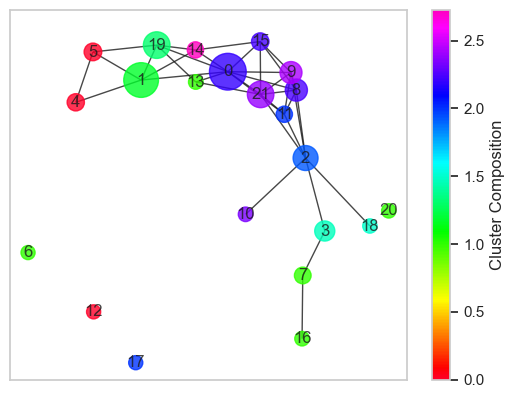

In [2420]:
# TDA-BM plot of cluster composition

bmx1 = df_pivot[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(df_pivot['Cluster'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='Cluster', color_palette=hsvp, colorbar=True, colorbar_label="Cluster Composition",
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))

plt.grid(False)  # This removes gridlines

# Show the plot
plt.show()

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



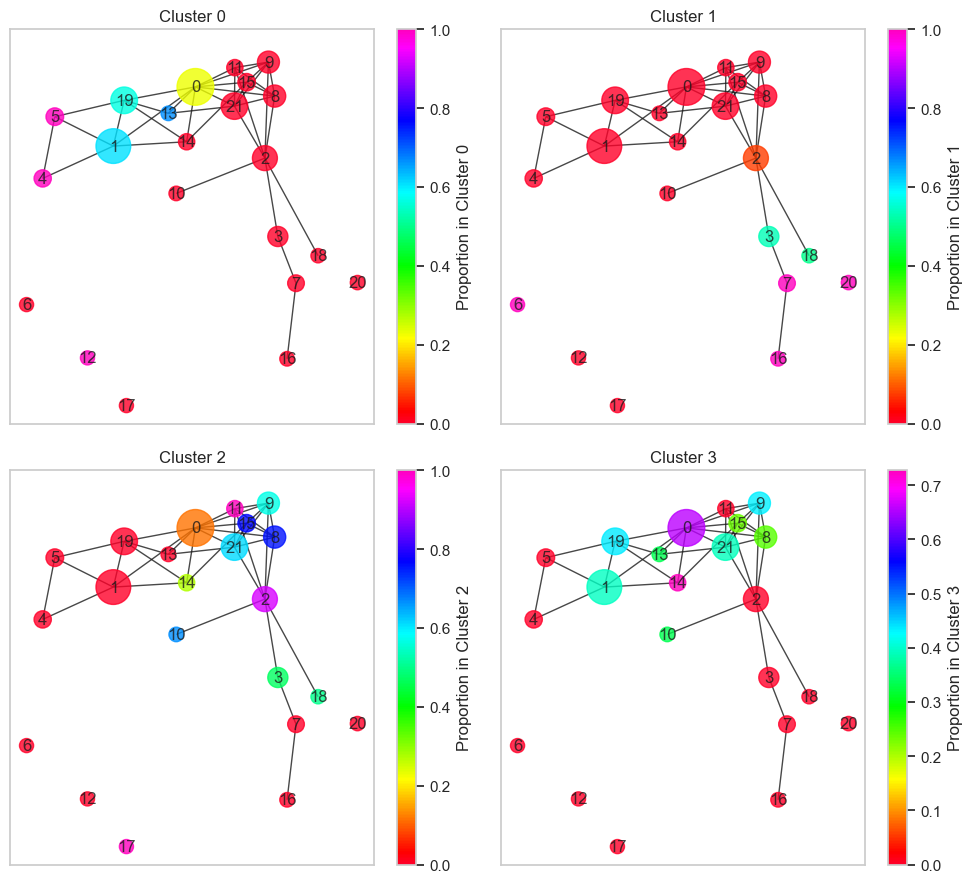

In [2421]:
# TDA-BM plot for all clusters

# Create a figure with 1 row and 2 columns for the two plots
fig, axes = plt.subplots(2, 2, figsize=(10, 9))  # Adjust figsize for appropriate sizing

# Plot 1: cluster 0
bmx1 = df_wider[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf_cluster_0 = pd.DataFrame(df_wider['Cluster_0'])
bm_cluster_0 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_cluster_0)
hsvp = cm.get_cmap("gist_rainbow")

# Draw tda 
bm_cluster_0.draw_networkx(coloring_variable='Cluster_0', color_palette=hsvp, colorbar=True, colorbar_label="Proportion in Cluster 0",
                            pos=nx.spring_layout(bm_cluster_0.Graph, k=0.7, seed=55), ax=axes[0, 0])
axes[0, 0].set_title('Cluster 0')
axes[0, 0].grid(False)

# Plot 2: cluster 1
cdf_cluster_1 = pd.DataFrame(df_wider['Cluster_1'])
bm_cluster_1 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_cluster_1)

# Draw tda for it
bm_cluster_1.draw_networkx(coloring_variable='Cluster_1', color_palette=hsvp, colorbar=True, colorbar_label="Proportion in Cluster 1",
                         pos=nx.spring_layout(bm_cluster_1.Graph, k=0.7, seed=55), ax=axes[0, 1])
axes[0, 1].set_title('Cluster 1')
axes[0, 1].grid(False)

# Plot 3 :cluster 2
cdf_cluster_2 = pd.DataFrame(df_wider['Cluster_2'])
bm_cluster_2 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_cluster_2)

# Draw network for cluster 2
bm_cluster_2.draw_networkx(coloring_variable='Cluster_2', color_palette=hsvp, colorbar=True, colorbar_label="Proportion in Cluster 2",
                         pos=nx.spring_layout(bm_cluster_2.Graph, k=0.7, seed=55), ax=axes[1, 0])
axes[1, 0].set_title('Cluster 2')
axes[1, 0].grid(False)

# plot 4 for cluster 3

cdf_cluster_3 = pd.DataFrame(df_wider['Cluster_3'])
bm_cluster_3 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_cluster_3)

# Draw network for cluster 
bm_cluster_3.draw_networkx(coloring_variable='Cluster_3', color_palette=hsvp, colorbar=True, colorbar_label="Proportion in Cluster 3",
                         pos=nx.spring_layout(bm_cluster_3.Graph, k=0.7, seed=55), ax=axes[1, 1])
axes[1, 1].set_title('Cluster 3')
axes[1, 1].grid(False)

# Display the combined figure
plt.tight_layout()
plt.show()

In [2422]:
# get the points for merging
pb1 = bm1.points_and_balls()
df_pivot['point'] = df_pivot.index 
df_pivot = df_pivot.merge(pb1, on='point')

In [2423]:
# inspect
df_pivot.head()

Local_Authority  Cluster  salaries_2020  salaries_2021  salaries_2022  \
0   Aberdeen City        3        28113.0        26848.0        26689.0   
1   Aberdeenshire        2        31194.0        28747.0        28895.0   
2   Aberdeenshire        2        31194.0        28747.0        28895.0   
3   Aberdeenshire        2        31194.0        28747.0        28895.0   
4   Aberdeenshire        2        31194.0        28747.0        28895.0   

   salaries_2023  point  ball  
0        27335.0      0     0  
1        28230.0      1     0  
2        28230.0      1     8  
3        28230.0      1     9  
4        28230.0      1    15

Text(0.5, 33.249999999999986, 'Cluster')

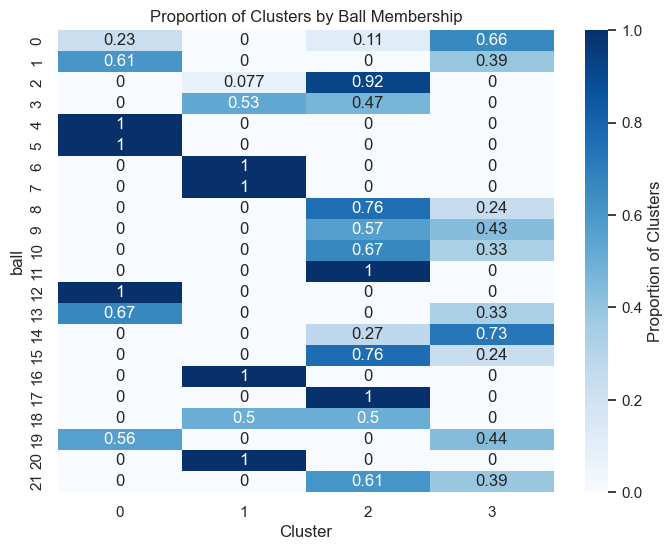

In [2424]:
# a heatmap of the clusters

# Group by 'ball' and 'Cluster' to count occurrences
cluster_counts = df_pivot.groupby(['ball', 'Cluster']).size().reset_index(name='count')

# Calculate total counts per 'ball' to calculate proportions
total_counts_per_ball = cluster_counts.groupby('ball')['count'].transform('sum')

# Calculate the proportion of each cluster within each ball
cluster_counts['proportion'] = cluster_counts['count'] / total_counts_per_ball

# Pivot the data for easier plotting
pivot_df = cluster_counts.pivot(index='ball', columns='Cluster', values='proportion').fillna(0)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='Blues', cbar_kws={'label': 'Proportion of Clusters'})
plt.title('Proportion of Clusters by Ball Membership')
plt.xlabel('Cluster')

In [2425]:
# check the regions data
regions.head()

LAD21CD                   LAD21NM    RGN21CD                   RGN21NM  \
0  E06000001                Hartlepool  E12000001                North East   
1  E06000011  East Riding of Yorkshire  E12000003  Yorkshire and The Humber   
2  E06000002             Middlesbrough  E12000001                North East   
3  E06000003      Redcar and Cleveland  E12000001                North East   
4  E06000012   North East Lincolnshire  E12000003  Yorkshire and The Humber   

   FID  
0    1  
1    2  
2    3  
3    4  
4    5

In [2426]:
# transform the region data and get ready for merging

regions.drop(['LAD21CD', 'RGN21CD', 'FID'], axis=1, inplace=True)
regions.rename(columns={'LAD21NM': 'Local_Authority'}, inplace=True)
regions.rename(columns={'RGN21NM': 'region'}, inplace=True)

In [2427]:
# regions data is only for England. Manually make one for Wales 

# List of local authorities
local_authorities = [
    "Blaenau Gwent", "Bridgend", "Caerphilly", "Cardiff", "Carmarthenshire",
    "Ceredigion", "Conwy", "Denbighshire", "Flintshire", "Gwynedd",
    "Isle of Anglesey", "Merthyr Tydfil", "Monmouthshire", "Neath Port Talbot",
    "Newport", "Pembrokeshire", "Powys", "Rhondda Cynon Taff", "Swansea",
    "Torfaen", "Vale of Glamorgan", "Wrexham"
]

# Create the DataFrame
wales = pd.DataFrame({
    'Local_Authority': local_authorities,
    'region': ['Wales'] * len(local_authorities)
})

# Display the DataFrame
print(wales)

       Local_Authority region
0        Blaenau Gwent  Wales
1             Bridgend  Wales
2           Caerphilly  Wales
3              Cardiff  Wales
4      Carmarthenshire  Wales
5           Ceredigion  Wales
6                Conwy  Wales
7         Denbighshire  Wales
8           Flintshire  Wales
9              Gwynedd  Wales
10    Isle of Anglesey  Wales
11      Merthyr Tydfil  Wales
12       Monmouthshire  Wales
13   Neath Port Talbot  Wales
14             Newport  Wales
15       Pembrokeshire  Wales
16               Powys  Wales
17  Rhondda Cynon Taff  Wales
18             Swansea  Wales
19             Torfaen  Wales
20   Vale of Glamorgan  Wales
21             Wrexham  Wales


In [2428]:
# make data for Scotland as well

# List of local authorities in Scotland
scottish_local_authorities = [
    "Aberdeen City", "Aberdeenshire", "Angus", "Argyll and Bute", "City of Edinburgh",
    "Clackmannanshire", "Dumfries and Galloway", "Dundee City", "East Ayrshire", 
    "East Dunbartonshire", "East Lothian", "East Renfrewshire", "Falkirk", "Fife", 
    "Glasgow City", "Highland", "Inverclyde", "Midlothian", "Moray", 
    "Na h-Eileanan Siar", "North Ayrshire", "North Lanarkshire", "Orkney Islands", 
    "Perth and Kinross", "Renfrewshire", "Scottish Borders", "Shetland Islands", 
    "South Ayrshire", "South Lanarkshire", "Stirling", "West Dunbartonshire", "West Lothian"
]

# Create the DataFrame
df_scotland = pd.DataFrame({
    'Local_Authority': scottish_local_authorities,
    'region': ['Scotland'] * len(scottish_local_authorities)
})

# Display the DataFrame
print(df_scotland)

          Local_Authority    region
0           Aberdeen City  Scotland
1           Aberdeenshire  Scotland
2                   Angus  Scotland
3         Argyll and Bute  Scotland
4       City of Edinburgh  Scotland
5        Clackmannanshire  Scotland
6   Dumfries and Galloway  Scotland
7             Dundee City  Scotland
8           East Ayrshire  Scotland
9     East Dunbartonshire  Scotland
10           East Lothian  Scotland
11      East Renfrewshire  Scotland
12                Falkirk  Scotland
13                   Fife  Scotland
14           Glasgow City  Scotland
15               Highland  Scotland
16             Inverclyde  Scotland
17             Midlothian  Scotland
18                  Moray  Scotland
19     Na h-Eileanan Siar  Scotland
20         North Ayrshire  Scotland
21      North Lanarkshire  Scotland
22         Orkney Islands  Scotland
23      Perth and Kinross  Scotland
24           Renfrewshire  Scotland
25       Scottish Borders  Scotland
26       Shetland Islands  S

In [2429]:
# Make data for Northern Ireland 

northern_ireland_local_authorities = [
    "Antrim and Newtownabbey", 
    "Armagh City, Banbridge and Craigavon", 
    "Belfast", 
    "Causeway Coast and Glens", 
    "Derry City and Strabane", 
    "Fermanagh and Omagh", 
    "Lisburn and Castlereagh", 
    "Mid and East Antrim", 
    "Mid Ulster", 
    "Newry, Mourne and Down", 
    "Ards and North Down"
]

# Create the DataFrame
df_northern_ireland = pd.DataFrame({
    'Local_Authority': northern_ireland_local_authorities,
    'region': ['Northern Ireland'] * len(northern_ireland_local_authorities)
})

# Display the DataFrame
print(df_northern_ireland)

                         Local_Authority            region
0                Antrim and Newtownabbey  Northern Ireland
1   Armagh City, Banbridge and Craigavon  Northern Ireland
2                                Belfast  Northern Ireland
3               Causeway Coast and Glens  Northern Ireland
4                Derry City and Strabane  Northern Ireland
5                    Fermanagh and Omagh  Northern Ireland
6                Lisburn and Castlereagh  Northern Ireland
7                    Mid and East Antrim  Northern Ireland
8                             Mid Ulster  Northern Ireland
9                 Newry, Mourne and Down  Northern Ireland
10                   Ards and North Down  Northern Ireland


In [2430]:
# check the data
regions.head()

Local_Authority                    region
0                Hartlepool                North East
1  East Riding of Yorkshire  Yorkshire and The Humber
2             Middlesbrough                North East
3      Redcar and Cleveland                North East
4   North East Lincolnshire  Yorkshire and The Humber

In [2431]:
# add them together
regions_combined = pd.concat([regions, wales, df_scotland, df_northern_ireland], ignore_index=True)


In [2432]:
# add regions data to the TDA data
regional_TDA = TDA_data.merge(regions_combined, on='Local_Authority', how = 'left')

In [2433]:
# check
regional_TDA.head()

Local_Authority  resilience_indicator  point  ball  Year  salaries    region
0   Aberdeen City                     0      0     0  2020   28113.0  Scotland
1   Aberdeenshire                     0      1     0  2020   31194.0  Scotland
2   Aberdeenshire                     0      1     8  2020   31194.0  Scotland
3   Aberdeenshire                     0      1     9  2020   31194.0  Scotland
4   Aberdeenshire                     0      1    15  2020   31194.0  Scotland

In [2434]:
# check n of las
regional_TDA['Local_Authority'].nunique()

352

In [2435]:
# check n of las
TDA_data['Local_Authority'].nunique()

352

In [2436]:
# prepare data
df = regional_TDA.drop(columns=['ball', 'point', 'resilience_indicator'])

#  Pivot the 'salaries' column to create separate columns for each year
df_pivoted = df.pivot_table(
    index=['Local_Authority', 'region'], 
    columns='Year', 
    values='salaries'
).reset_index()

# Rename columns for clarity 
df_pivoted.columns = ['Local_Authority', 'region'] + [f'salaries_{int(col)}' for col in df_pivoted.columns[2:]]

# get dummy vars for regions
regional_TDA = pd.get_dummies(df_pivoted, columns=['region'], dtype=int)



/var/folders/kh/kvrs5sp15tx0d3k647zd9b540000gn/T/ipykernel_33340/1257329377.py:5: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



# TDA-BM of LAs focused on regional membership

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaco

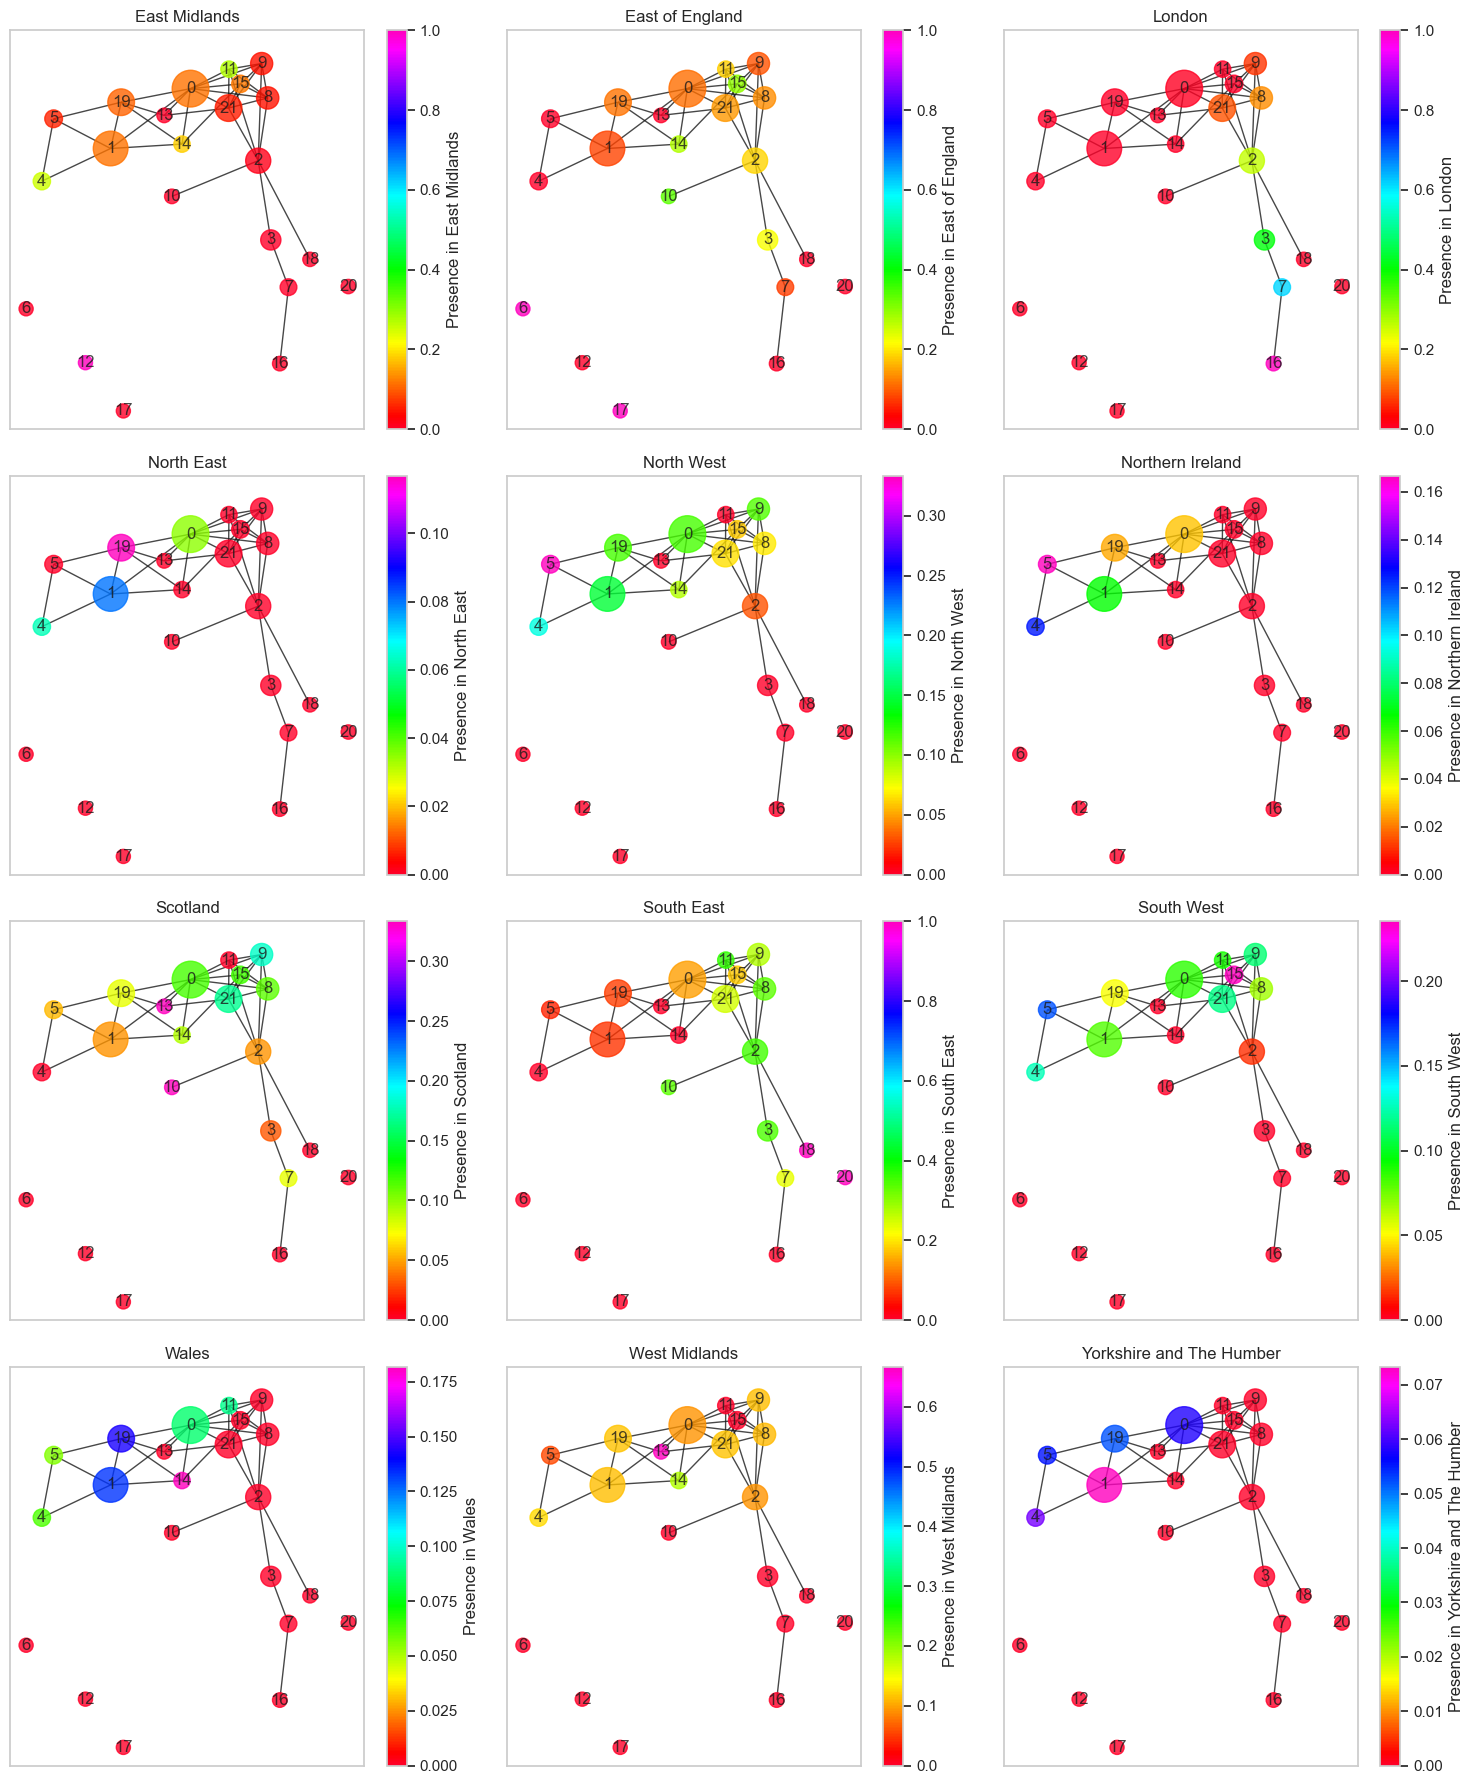

In [2437]:
# a plot of regional membership to inform the analysis

region_columns = [
    'region_East Midlands', 'region_East of England', 'region_London', 'region_North East', 
    'region_North West', 'region_Northern Ireland', 'region_Scotland', 'region_South East', 
    'region_South West', 'region_Wales', 'region_West Midlands', 'region_Yorkshire and The Humber'
]
# Create a figure with 4 rows and 3 columns for the 12 plots
fig, axes = plt.subplots(4, 3, figsize=(15, 18))  # Adjust figsize for appropriate sizing

# Common X data
bmx1 = regional_TDA[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
hsvp = cm.get_cmap("gist_rainbow")

# Iterate over each region to create plots
for idx, region_col in enumerate(region_columns):
    # Determine subplot position
    row, col = divmod(idx, 3)
    
    # Prepare coloring data for the current region
    cdf_region = pd.DataFrame(regional_TDA[region_col])
    bm_region = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_region)
    
    # Draw network for the current region
    bm_region.draw_networkx(
        coloring_variable=region_col, 
        color_palette=hsvp, 
        colorbar=True, 
        colorbar_label=f"Presence in {region_col.replace('region_', '').replace('_', ' ')}",
        pos=nx.spring_layout(bm_region.Graph, k=0.7, seed=55), 
        ax=axes[row, col]
    )
    
    # Set title for each subplot
    axes[row, col].set_title(region_col.replace('region_', '').replace('_', ' '))
    axes[row, col].grid(False)

# Adjust layout and display the combined figure
plt.tight_layout()
plt.show()

In [2438]:
# get points and ball membership
pb1 = bm1.points_and_balls()
regional_TDA['point'] = regional_TDA.index
regional_TDA = regional_TDA.merge(pb1, on='point')

In [2439]:
# last visual inspection
regional_TDA.head()

Local_Authority  salaries_2020  salaries_2021  salaries_2022  salaries_2023  \
0   Aberdeen City        28113.0        26848.0        26689.0        27335.0   
1   Aberdeenshire        31194.0        28747.0        28895.0        28230.0   
2   Aberdeenshire        31194.0        28747.0        28895.0        28230.0   
3   Aberdeenshire        31194.0        28747.0        28895.0        28230.0   
4   Aberdeenshire        31194.0        28747.0        28895.0        28230.0   

   region_East Midlands  region_East of England  region_London  \
0                     0                       0              0   
1                     0                       0              0   
2                     0                       0              0   
3                     0                       0              0   
4                     0                       0              0   

   region_North East  region_North West  region_Northern Ireland  \
0                  0                  0                        0   
1                  0                  0                        0   
2                  0                  0                        0   
3                  0                  0                        0   
4                  0                  0                        0   

   region_Scotland  region_South East  region_South West  region_Wales  \
0                1                  0                  0             0   
1                1                  0                  0             0   
2                1                  0                  0             0   
3                1                  0                  0             0   
4                1                  0                  0             0   

   region_West Midlands  region_Yorkshire and The Humber  point  ball  
0                     0                                0      0     0  
1                     0                                0      1     0  
2                     0                                0      1     8  
3                     0                                0      1     9  
4                     0                                0      1    15